# Agent

In [ ]:
#pip install -U duckduckgo-search

In [1]:
#gemini setting
import google.generativeai as genai

#os_key Setting

from dotenv import load_dotenv
import os
# .env 파일 로드(api key load) 
#GOOGLE_API_KEY 
#LANGCHAIN_API_KEY 
#TAVILY_API_KEY 
#HUGGINGFACEHUB_API_TOKEN 
#COHERE_API_KEY 

load_dotenv()

# GOOGLE_API_KEY 환경 변수 값 가져오기
google_api_key = os.getenv('GOOGLE_API_KEY')

# genai.configure로 GOOGLE API KEY Setting하기기
genai.configure(api_key=google_api_key)

In [2]:
# Helper
def visualize_graph(graph):
    from IPython.display import Image, display
    try:
        display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
    except Exception:
        # This requires some extra dependencies and is optional
        pass

In [3]:
import google.generativeai as genai


for model in genai.list_models():
    if 'generateContent' in model.supported_generation_methods:
        print(model.name)

models/gemini-1.0-pro-latest
models/gemini-1.0-pro
models/gemini-pro
models/gemini-1.0-pro-001
models/gemini-1.0-pro-vision-latest
models/gemini-pro-vision
models/gemini-1.5-pro-latest
models/gemini-1.5-pro-001
models/gemini-1.5-pro-002
models/gemini-1.5-pro
models/gemini-1.5-flash-latest
models/gemini-1.5-flash-001
models/gemini-1.5-flash-001-tuning
models/gemini-1.5-flash
models/gemini-1.5-flash-002
models/gemini-1.5-flash-8b
models/gemini-1.5-flash-8b-001
models/gemini-1.5-flash-8b-latest
models/gemini-1.5-flash-8b-exp-0827
models/gemini-1.5-flash-8b-exp-0924
models/gemini-2.0-flash-exp
models/gemini-2.0-flash
models/gemini-2.0-flash-001
models/gemini-2.0-flash-lite-preview
models/gemini-2.0-flash-lite-preview-02-05
models/gemini-2.0-pro-exp
models/gemini-2.0-pro-exp-02-05
models/gemini-exp-1206
models/gemini-2.0-flash-thinking-exp-01-21
models/gemini-2.0-flash-thinking-exp
models/gemini-2.0-flash-thinking-exp-1219
models/learnlm-1.5-pro-experimental


In [4]:
#gemini chatbot setting
from langchain_google_genai import ChatGoogleGenerativeAI

#llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash-thinking-exp", temperature=0)

llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash", temperature=0)

Custom Tool 정의

In [19]:
from langchain.tools import tool
from langchain.tools import BaseTool
from bs4 import BeautifulSoup
import requests
import time
import re

In [113]:
from pydantic import BaseModel, Field
from typing import List
import json

class SearchInput(BaseModel):
    query: str = Field(description='검색 query')
    max_results : int = Field(default=5, description="반환할 최대 결과 수")


class ResultItem(BaseModel):
    title: str = Field(description="검색 결과의 제목")
    url: str = Field(description="검색 결과의 URL")
    description: str = Field(description="검색 결과의 요약")

class SearchResult(BaseModel):
    query: str = Field(description="검색에 사용된 쿼리")
    results: List[ResultItem] = Field(description="검색 결과 목록")


In [123]:
class Web_search(BaseTool):
    name: str = "web_search"
    description : str = "Bing을 사용해서 Web_search를 합니다."
    
    def _run(query: str, max_results: int=5) -> SearchResult:

        headers = {'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36'}
        search_url = f"https://www.bing.com/search?q={query}"
        response = requests.get(search_url, headers=headers)
        time.sleep(5)
        soup = BeautifulSoup(response.text, 'html.parser')

        k = soup.find_all('a', target='_blank')
        news = []
        for i in k:
            if i['href'][0:4] == 'http':
                news.append(i)

        description = soup.find_all('p',class_=re.compile("^b_lineclamp"))

        search_results = []
        for index,content in enumerate(description[:max_results]):
            #print(news[index].contents[0])
            #print(news[index]['href'])
            #print(content.contents[0])
            search_results.append({
                        'title': news[index].contents[0],
                        'url': news[index]['href'],
                        'description': content.contents[0]})

        return SearchResult(query=query, results=search_results)

In [143]:
@tool
def web_search(query: str) -> str:
    """Bing 검색 결과를 스크래핑하여 관련 콘텐츠를 반환합니다."""

    headers = {'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36'}
    search_url = f"https://www.bing.com/search?q={query}"
    response = requests.get(search_url, headers=headers)
    time.sleep(5)
    soup = BeautifulSoup(response.text, 'html.parser')

    k = soup.find_all('a', target='_blank')
    news = []
    for i in k:
        if i['href'][0:4] == 'http':
            news.append(i)
    
    description = soup.find_all('p',class_=re.compile("^b_lineclamp"))

    search_results = []
    for index,content in enumerate(description):
        #print(news[index].contents[0])
        #print(news[index]['href'])
        #print(content.contents[0])
        search_results.append({
                    'title': news[index].contents[0],
                    'link': news[index]['href'],
                    'description': content.contents[0]})
        
    # 검색 결과에서 링크와 요약 추출
    results = []

    for news in search_results:
        
        results.append(f"{news['title']}\n{news['description']}\n{news['link']}")

    return "\n\n".join(results)  # 상위 10개 결과 반환

In [145]:
from langchain.agents import initialize_agent
from langchain_openai import ChatOpenAI

#llm = ChatOpenAI(model="gpt-3.5-turbo")
llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash-thinking-exp", temperature=0)
tools = [web_search]  # 커스텀 도구 추가

agent = initialize_agent(
    tools,
    llm,
    agent="zero-shot-react-description",
    verbose=True
)

In [146]:
response = agent.invoke("RSS Feed에 대해서 설명해 줘")
print(response)



> Entering new AgentExecutor chain...
Thought: RSS Feed에 대한 설명을 제공하기 위해 웹 검색을 사용해야 합니다. "RSS Feed 란"과 같은 검색어를 사용하여 한국어로 된 정보를 찾아보겠습니다.
Action: web_search
Action Input: RSS Feed 란
Observation: 
Thought:Thought: RSS Feed에 대한 설명을 제공하기 위해 웹 검색을 사용해야 합니다. "RSS Feed 란"과 같은 검색어를 사용하여 한국어로 된 정보를 찾아보겠습니다.
Action: web_search
Action Input: RSS Feed 란
Observation: 
Thought:Thought: RSS Feed에 대한 설명을 제공하기 위해 웹 검색을 사용해야 합니다. "RSS Feed 란"과 같은 검색어를 사용하여 한국어로 된 정보를 찾아보겠습니다.
Action: web_search
Action Input: RSS Feed 란

KeyboardInterrupt: 

In [108]:
# 에이전트 실행
response = agent.invoke({'chat_history':[],input:"일론 머스크에 대해서 설명해 줘"})
print(response)



> Entering new AgentExecutor chain...


ValueError: Missing some input keys: {'\n          "title"', 'input'}

In [ ]:
def search(query: str, max_results: int=5) -> str:
    headers = {'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36'}
    search_url = f"https://www.bing.com/search?q={query}"
    response = requests.get(search_url, headers=headers)
    time.sleep(5)
    soup = BeautifulSoup(response.text, 'html.parser')
    k = soup.find_all('a', target='_blank')
    print(k)
    news = []
    for i in k:
        if i['href'][0:4] == 'http':
            news.append(i)
    description = soup.find_all('p',class_=re.compile("^b_lineclamp"))
    search_results = []
    for index,content in enumerate(description[:max_results]):
        #print(news[index].contents[0])
        #print(news[index]['href'])
        #print(content.contents[0])
        search_results.append({
                    'title': news[index].contents[0],
                    'link': news[index]['href'],
                    'description': content.contents[0]})
    return search_results

In [84]:
k = search(query='HBM3E',max_results=3)

[<a h="ID=SERP,5125.2" href="https://m.blog.naver.com/techref/223398700515" target="_blank">HBM 반도체 뜻 HBM3 <strong>HBM3E</strong> 차이 고대역폭 메모리 특징 - 네이버 …</a>, <a h="ID=SERP,5144.2" href="https://news.skhynix.co.kr/presscenter/hbm3e-production" target="_blank">SK하이닉스, 초고성능 AI 메모리 ‘<strong>HBM3E</strong>’ 세계 최초로 본격 ...</a>, <a h="ID=SERP,5163.2" href="https://m.blog.naver.com/jkhan012/223386755360" target="_blank"><strong>HBM3E</strong>, 알아야 할 모든 것 - HBM은 패키징 기술 - 네이버 블로그</a>, <a h="ID=SERP,5182.2" href="https://biz.newdaily.co.kr/site/data/html/2025/01/31/2025013100117.html" target="_blank">입 다문 삼성, <strong>HBM3E</strong> 엔비디아 퀄테스트 통과 사실일까</a>, <a h="ID=SERP,5198.2" href="https://product.skhynix.com/products/dram/hbm/hbm3e.go" target="_blank"><strong>HBM3E</strong> | SK hynix</a>, <a h="ID=SERP,5217.2" href="https://news.skhynix.co.kr/post/skhynix-hbm3e-interview" target="_blank">“글로벌 No.1 AI 메모리 기업, SK하이닉스!” 세계 최고 성능 AI용 ...</a>, <a h="ID=SERP,5236.2" href="https://news.skhynix.co.kr/pr

In [82]:
k

[{'title': 'HBM 반도체 뜻 HBM3 ',
  'link': 'https://m.blog.naver.com/techref/223398700515',
  'description': '2024년 3월 28일\xa0· 바로 hbm3e입니다. hbm3e는 용량과 속도 면에서 hbm3을 뛰어넘는 개선된 버전입니다. 삼성전자가 개발한 36gb 용량의 hbm3e 12단 적층 d램은 업계에서 가장 큰 용량을 자랑하며, 초당 1,280gb의 대역폭을 제공합니다. 이는 hbm3 대비 50% 이상 향상된 성능입니다.'},
 {'title': 'SK하이닉스, 초고성능 AI 메모리 ‘',
  'link': 'https://news.skhynix.co.kr/presscenter/hbm3e-production',
  'description': '2024년 3월 19일\xa0· sk하이닉스가 hbm 5세대 hbm3e d램에서도 ai 메모리 선도 기업의 위상을 공고히 한다. SK하이닉스는 초고성능 AI용 메모리 신제품인 HBM3E*를 세계 최초로 양산해 3월 말부터 제품 공급을 시작한다고 19일 밝혔다.'},
 {'title': <strong>HBM3E</strong>,
  'link': 'https://m.blog.naver.com/jkhan012/223386755360',
  'description': '2024년 3월 18일\xa0· hbm3e는 hbm2e, hbm2 또는 hbm(gen 1)과 어떻게 다릅니까? HBM3는 HBM 표준의 세 번째 주요 세대입니다. 세대가 거듭될수록 데이터 속도, 3D 스택 높이, DRAM 칩 밀도가 증가하는 추세를 보이고 있습니다.'}]

#proxy 설정시

In [ ]:
from langchain.tools import DuckDuckGoSearchRun

search = DuckDuckGoSearchRun(proxy="http://your-proxy-url:port")

In [ ]:
import os
os.environ['DDGS_PROXY'] = "http://your-proxy-url:port"

from langchain.tools import DuckDuckGoSearchRun

#proxy 설정 없는 경우

In [28]:
from langchain.tools import DuckDuckGoSearchResults


#공통 부분

In [40]:
#DuckDuckGoSearchRun 인스턴스를 생성합니다(5개 찾기기)
search = DuckDuckGoSearchResults(output_format="json")

In [30]:
search.__dict__

{'name': 'duckduckgo_results_json',
 'description': 'A wrapper around Duck Duck Go Search. Useful for when you need to answer questions about current events. Input should be a search query. Output is a JSON string array of the query results',
 'args_schema': langchain_community.tools.ddg_search.tool.DDGInput,
 'return_direct': False,
 'verbose': False,
 'callbacks': None,
 'callback_manager': None,
 'tags': None,
 'metadata': None,
 'handle_tool_error': False,
 'handle_validation_error': False,
 'response_format': 'content',
 'max_results': 10,
 'api_wrapper': DuckDuckGoSearchAPIWrapper(region='wt-wt', safesearch='moderate', time='y', max_results=5, backend='api', source='text'),
 'backend': 'text',
 'keys_to_include': None,
 'results_separator': ', '}

In [44]:
results = search.invoke("액침 냉각")
print(results)

C:\Users\choiw\AppData\Roaming\Python\Python310\site-packages\langchain_community\utilities\duckduckgo_search.py:64: UserWarning: backend='api' is deprecated, using backend='auto'
  ddgs_gen = ddgs.text(


snippet: 액침 냉각 기술은 배터리를 냉각액으로 둘러싸 열 축적을 방지하고, 안정성과 수명을 연장합니다. 예 : gs칼텍스와 에쓰오일은 전기차 및 에너지 저장 장치(ess)에 적합한 다양한 액침 냉각유를 개발하여 배터리 기술의 안전성을 크게 향상하고 있습니다 ., title: Ai시대 열관리 최고의 기술 : 액침냉각의 정의와 종류, 적용 분야 총정리, link: https://one-economy.tistory.com/entry/액침냉각-정의-종류, snippet: 액침 냉각(Immersion Cooling)은 전체 서버를 공기보다 열 전도율이 상당히 높은 유전체 전기 비전도성 유체에 담구는 IT 냉각 방식입니다. 냉각수를 뜨거운 구성 요소와 직접 접촉시키고, 가열된 액체를 열교환기를 통해 순환시켜 시스템에서 열을 제거합니다. ..., title: 액침냉각 관련정리(엔지니어 Tv) : 네이버 블로그, link: https://m.blog.naver.com/chcmg2022/223354689838, snippet: 액침냉각 기술은 최근 급격히 주목받고 있으며, 액체 금속을 사용하여 열을 전달하는 혁신적인 열 관리 기술입니다. 이는 전자 기기의 성능 향상과 발열량 감소에 기여합니다. 이번 글에서는 액침냉각 기술의 정의, 원리, 시장 규모 및 전망, 주요 응용 분야..., title: 액침냉각: 혁신적인 열 관리 기술의 심층 분석 - 그 남자의 이야기, link: https://tmsstory.co.kr/액침냉각-기술-정의-원리-전망-기업/, snippet: 액침 냉각이란? 액침 냉각은 전자 기기를 전기가 통하지 않는 액체에 직접 담가 열을 식히는 혁신적인 냉각 기술입니다. 공기 냉각이나 수냉각 방식과 달리 액체가 기판과 부품과 직접 접촉하여 열을 빠르고 효율적으로 전달하기 때문에 기본적으로 많은 열이 발생하는 고성능 전자기기나 대규모 ..., title: 액침 냉각이란? 액침 냉각의 장점과 활용 분야, link: https://in-dok.tistory.co

In [42]:
type(results)

str

In [43]:
results

'snippet: 오늘 이재명 더불어민주당 대표의 공직선거법 위반 사건 2심 절차가 시작됐어요.이 사건은 이 대표의 정치적 운명을 좌우할 수 있는 중요한 사안인 만큼, 많은 국민들의 관심이 집중되고 있죠. 그럼 지금부터 2심 절차의 시작과 향후 일정, 그리고 이것이 가져올 정치적 파장에 대해 함께 ..., title: 이재명 대표 공직선거법 위반 2심 시작: 판결일, 주요 쟁점 및 향후 일정, link: https://postian.tistory.com/entry/이재명-대표-공직선거법-위반-2심-시작-판결일-주요-쟁점-및-향후-일정, snippet: 이재명 더불어민주당 대표의 공직선거법 위반 혐의 2심 재판이 5일 열렸다. 서울고법 형사6-2부(재판장 최은정)는 이날 이 대표의 선거법 위반 사건 2차 변론 기일을 열고 전날 이 대표 측이 신청한 위헌법률심판 제청에 대한 검찰과 이 대표 측의 의견을 들었다., title: 이재명 공직선거법 위반 2심 2차변론기일 열려.... 결론은 언제?, link: https://monthly.chosun.com/client/Mdaily/daily_view.asp?Idx=21374&Newsnumb=20250221374, snippet: 더불어민주당 이재명 대표의 공직선거법 위반 사건 항소심 2차 공판이 열렸다. 이 대표 측이 위헌법률심판 제청을 신청한 가운데, 검찰은 피고인이 ..., title: 이재명 \'선거법 위반\' 2차 공판…檢 "위헌법률심판 제청 기각해야" - 이투데이, link: https://www.etoday.co.kr/news/view/2442588, snippet: 이재명 더불어민주당 대표의 공직선거법 위반 사건이 오는 23일부터 시작된다. 서울고등법원 형사6-2부는 항소심 첫 공판기일을 이날 오후 3시로 지정했다고 2일 밝혔다. 공판기일에는 양측의 항소이유 요지 진술 및 증거 채택 ..., title: 이재명 선거법 2심, 23일 시작…\'6·3·3 원칙\' 깨질판 | 중앙일보, link: https:/

In [65]:
from langchain.agents import initialize_agent

llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash-thinking-exp", temperature=0)

#tools = [web_search]  # 커스텀 도구 추가


tools = [DuckDuckGoSearchRun()]

agent = initialize_agent(tools, llm, agent="zero-shot-react-description", verbose=True)

In [69]:
response = agent.run("일론 머스크에 대해서 설명해 줘")
print(response)



> Entering new AgentExecutor chain...
Thought: The question is asking for an explanation about Elon Musk in Korean. I should use the `duckduckgo_search` tool to find information about Elon Musk and then summarize it in Korean.
Action: duckduckgo_search
Action Input: 일론 머스크

C:\Users\choiw\AppData\Roaming\Python\Python310\site-packages\langchain_community\utilities\duckduckgo_search.py:64: UserWarning: backend='api' is deprecated, using backend='auto'
  ddgs_gen = ddgs.text(



Observation: Elon Musk is founder of Tesla Motors and SpaceX among other companies. Read about his net worth, children, ex-wives, age, home country, DOGE position, and more. 애슐리 반스가 쓴 《일론 머스크: 미래의 설계자》에 따르면 "어린 시절 머스크 일가의 집은 프리토리아에서 가장 큰 집 중 하나였고 에롤은 가족들과 자주 해외여행을 갔다."라고 설명하고 있다. [3] Elon Musk cofounded seven companies, including electric car maker Tesla, rocket producer SpaceX and artificial intelligence startup xAI. He owns about 12% of Tesla excluding options, but has ... 일론 머스크, '세계 최고 부자' 타이틀 탈환... 순자산 253조원 2023년 6월 2일 머스크의 인터뷰에서 알게 된 6가지 2023년 4월 13일 미국의 정부효율부 수장에 발탁된 일론 머스크는 과연 미 정부 예산의 30%에 달하는 금액인 2조 달러를 줄일 수 있을까?
Thought:Thought: I now know the final answer
Final Answer: 일론 머스크는 테슬라, 스페이스X, xAI를 포함한 7개의 회사를 공동 창업한 기업가입니다. 그는 전기 자동차 회사 테슬라와 로켓 제조 회사 스페이스X의 설립자로 가장 잘 알려져 있습니다. 2023년 6월에는 순자산 253조 원으로 세계 최고 부자 타이틀을 되찾았습니다. 최근에는 미국 정부 예산 감축에 대한 인터뷰를 하기도 했습니다.

> Finished chain.
일론 머스크는 테슬라, 스페이스X, xAI를 포함한 7개의 회사를 공동 창업한 기업가입니다. 그는 전기 자동차 회사 테슬라와 로켓 제조 회사 스페이스X의 설립자로 가장 잘 알려져 있

In [67]:
response = agent.run("딥시크에 대한 기술 내용을 요약하고 출처도 알려줘")
print(response)



> Entering new AgentExecutor chain...
Thought: The question is asking for a summary of the technical details of "DeepSeek" in Korean and also wants to know the source of this information. To answer this, I need to use the `duckduckgo_search` tool to find information about DeepSeek and then summarize the technical details and provide the source.

Action: duckduckgo_search
Action Input: 딥시크 기술 상세

C:\Users\choiw\AppData\Roaming\Python\Python310\site-packages\langchain_community\utilities\duckduckgo_search.py:64: UserWarning: backend='api' is deprecated, using backend='auto'
  ddgs_gen = ddgs.text(



Observation: 1. 딥시크(DeepSeek)란?딥시크(DeepSeek, 深度求索)는 중국의 인공지능(AI) 연구 기업이자 오픈 소스 대형 언어 모델(LLM) 개발사입니다. 딥시크는 2023년 중국 헤지펀드 High-Flyer의 투자로 독립적인 AI 연구소로 출범했으며, 인공지능 연구와 언어 모델 개발을 집중적으로 수행하고 있습니다. 딥시크는 AI 모델을 ... 한국에서는 설 연휴가 한창이던 2024년 1월 27일, 중국의 AI 스타트업 딥시크(DeepSeek)가 R1 모델을 공개하며 글로벌 AI 업계의 이목을 집중시켰습니다. 나스닥을 비롯한 글로벌 증시가 크게 반응했고, 명절을 맞아 휴일을 즐기던 국내 언론사들도 긴급하게 뉴스를 전하기 바빴습니다. 도대체 딥시크가 ... 📋 목차💡 딥시크(DeepSeek)란?🔍 딥시크의 핵심 기술과 원리🚀 딥시크를 활용한 최신 AI 혁신 사례💰 딥시크가 비즈니스에 미치는 영향⚠️ 딥시크 사용 시 주의해야 할 점📈 딥시크의 미래 전망과 발전 가능성 딥시크 관련 자주 묻는 질문 (FAQ)최근 AI 기술이 급속도로 발전하면서, 딥시크(DeepSeek)가 ... 지난 10년 동안 중국은 '메이드 인 차이나 2025'라는 야심 찬 계획의 일환으로 AI를 포함한 여러 첨단 기술에 대한 전문성을 서서히 쌓아오고 있다. 딥시크는 중국의 AI 스타트업이 개발한 최첨단 인공지능 언어 모델입니다. 2025년 1월에 공개된 DeepSeek-R1 모델은 저비용 고효율을 자랑하며 ChatGPT와 같은 기존 AI 챗봇들과 경쟁하고 있습니다. 다국어 지원, 코딩 능력, 그리고 심층적인 추론 능력이 특징입니다. 이번 포스팅에서는 딥시크 (DeepSeek) 사용 ...
Thought:Thought: I now know the final answer
Final Answer: 딥시크(DeepSeek)는 중국의 인공지능 연구 기업으로, 오픈 소스 대형 언어 모델(LLM) 개발사입니다. 2023년 중국 헤지펀드 High-Flyer의 투자로 독립적인 AI 

In [50]:
response = agent.run("액침 냉각 기술의 종류를 표로 비교해 줘")
print(response)



> Entering new AgentExecutor chain...
Thought: The user is asking for a comparison table of different types of immersion cooling technology in Korean. I need to search for information about different types of immersion cooling technologies and then organize them into a table.
Action: duckduckgo_search
Action Input: 액침 냉각 기술 종류 비교표

C:\Users\choiw\AppData\Roaming\Python\Python310\site-packages\langchain_community\utilities\duckduckgo_search.py:64: UserWarning: backend='api' is deprecated, using backend='auto'
  ddgs_gen = ddgs.text(



Observation: 최근 AI시대를 맞이하며 방대한 데이터처리를 위해서는 막대한 에너지 소비가 수반되는데요 이러한 에너지 소비 최소화를 위한 핵심기술로 액침냉각이 주목을 받고 있습니다. 이번 시간에는 액침냉각의 원리와 종류, 적용 분야에 대하여 자세히 알아보겠습니다. 1. 액침냉각의 원리액침냉각은 ... 3)액침 은 서버를 아예 비전도성 액체(물x)에 담그는것. 다만 아직 상용화 전 단계임. 21년 마이크로소프트가 첫 액침냉각 솔루션 도입함. 전력 효율(pue)은 공냉 -> dtc -> 액침 순으로 좋음. 즉 수냉식은 공랭식 대비 액침은 수냉식 대비 pue를 1로 낮추기에 유리함 액침냉각(Immersion Cooling) 데이터센터 서버나 전자제품, 배터리 등을 전기가 통하지 않는 비전도성 액체에 침전하여 열을 식히는 차세대 열관리 기술 2. 액침냉각의 종류( 단상 / 2상) ... 데이터센터 냉각 기술의 종류. 1)냉각 방식 : a(열발생) to b(열흡수)를 매개하는 물/공기/부동액+냉매 조합에 따라 13가지 ... lgu+ : `24년 12월, gst와 액침 ... 액침냉각 방식은 기존 냉각 기술 대비 전력 소비량의 절반 가까이를 줄일 수 있어 탄소중립 시대를 위한 대표 열관리 기술로 떠오르고 있습니다. 2022년, 인텔이 액침냉각 기술 개발에 총 7억 달러를 투자한다고 발표한 사례는 해당 기술이 미래 산업 분야에서 ...
Thought:Thought:The user is asking for a comparison table of different types of immersion cooling technology in Korean. I need to search for information about different types of immersion cooling technologies and then organize them into a table. Based on the previous search results, the main types 

C:\Users\choiw\AppData\Roaming\Python\Python310\site-packages\langchain_community\utilities\duckduckgo_search.py:64: UserWarning: backend='api' is deprecated, using backend='auto'
  ddgs_gen = ddgs.text(



Observation: 2. 액침냉각의 종류. 액침냉각은 시스템의 열을 효율적으로 관리하기 위해 다양한 방식으로 구현됩니다. 크게 싱글 페이즈 냉각(Single-Phase Immersion Cooling)과 투 페이즈 냉각(Two-Phase Immersion Cooling)으로 구분되며, 각각의 원리와 특징, 적용 사례가 다릅니다. 단상 액침냉각 방식(Single-phase Immersion) '서버 → 펌프 → CUD → 서버' 의 순환 사이클 1-Phase Immersion Cooling System은 유전체 용액을 서버에 순환시켜 냉각하는 방식이다. LiquidStack: LiquidStack는 2상 액침냉각 기술의 선두주자로, 에너지 효율적인 솔루션을 제공하며 많은 투자를 받아 왔습니다. Green Revolution Cooling (GRC): GRC는 단상 액침냉각 기술을 전문으로 하며, Dell과 Intel과 같은 주요 IT 기업들과 협력합니다. 액침냉각에 사용되는 절연유체에 따라 단상(single-phase) 방식과 2상(two-phase) 방식이 있습니다. (1) 단상 방식 단상 방식의 경우 절연유체가 액체 상태로 순환하며, 전기 부품을 통과하면서 열을 흡수합니다. 액침냉각은 사용되는 절연유체에 따라 단상(Single Phase) 방식과 2상(Two-Phase) 방식이 있다. 액침 냉각(lmmersion Cooling)단상(Single Phase) 방식 / 사진 GRCOOLING.COM 단상방식은 절연유체가 액체 상태로 순환하며 전기 부품을 통과하면서 열을 흡수한다.
Thought:Thought:I now know the final answer
Final Answer:## 액침 냉각 기술 종류 비교표

| 구분 | 단상 액침 냉각 (Single-Phase Immersion Cooling) | 2상 액침 냉각 (Two-Phase Immersion Cooling) |
|---|---|---|
| **원리** |  절연 액체가 액체 상태로 순환하며 

In [70]:
from langchain.tools import tool
from bs4 import BeautifulSoup
import requests
import time
import re

@tool
def web_search(query: str) -> str:
    """Bing 검색 결과를 스크래핑하여 관련 콘텐츠를 반환합니다."""

    headers = {'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36'}
    search_url = f"https://www.bing.com/search?q={query}"
    response = requests.get(search_url, headers=headers)
    time.sleep(5)
    soup = BeautifulSoup(response.text, 'html.parser')

    k = soup.find_all('a', target='_blank')
    news = []
    for i in k:
        if i['href'][0:4] == 'http':
            news.append(i)
    
    description = soup.find_all('p',class_=re.compile("^b_lineclamp"))

    search_results = []
    for index,content in enumerate(description):
        #print(news[index].contents[0])
        print(news[index]['href'])
        #print(content.contents[0])
        search_results.append({
                    'title': news[index].contents[0],
                    'link': news[index]['href'],
                    'description': content.contents[0]})
        
    # 검색 결과에서 링크와 요약 추출
    results = []

    for news in search_results:
        
        results.append(f"{news['title']}\n{news['description']}\n{news['link']}")

    return "\n\n".join(results)  # 상위 10개 결과 반환

In [71]:
from langchain.agents import initialize_agent
from langchain_openai import ChatOpenAI

#llm = ChatOpenAI(model="gpt-3.5-turbo")
llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash-thinking-exp", temperature=0)
tools = [web_search]  # 커스텀 도구 추가

agent = initialize_agent(
    tools,
    llm,
    agent="zero-shot-react-description",
    verbose=True
)

In [72]:
response = agent.run("RSS Feed에 대해서 설명해 줘")
print(response)



> Entering new AgentExecutor chain...
Thought: RSS Feed에 대한 설명을 제공하기 위해 웹 검색을 사용해야 합니다. "RSS Feed 란"과 같은 검색어를 사용하여 한국어로 된 정보를 찾아보겠습니다.
Action: web_search
Action Input: RSS Feed 란https://hof.pe.kr/548
https://m.blog.naver.com/patchwork_corp/222485364227
https://m.blog.naver.com/jameschoie/222200558891
https://quddydwjswk.tistory.com/entry/RSS-%ED%94%BC%EB%93%9C%EC%9D%98-%EA%B0%9C%EB%85%90%EA%B3%BC-%EC%82%AC%EC%9A%A9%EB%B0%A9%EB%B2%95-RSS%EB%A6%AC%EB%8D%94
https://namu.wiki/w/RSS
https://ko.wikipedia.org/wiki/RSS
https://heyjihye.com/blog/rss-feed/
https://mwultong.blogspot.com/2007/10/rss-rss-feed.html
https://steemit.com/kr/@andydream/rss-rss
https://ko.site123.com/learn/rss%eb%9e%80-%eb%ac%b4%ec%97%87%ec%9d%b4%eb%a9%b0-%ec%99%9c-%ed%95%84%ec%9a%94%ed%95%9c%ea%b0%80

Observation: RSS란 무엇인가. (초보용) - hof
rss란 무엇인가? RSS는 Really Simple Syndication의 머리글자를 딴 말이며, 사이트에 새로 올라온 글을 쉽게 구독할 수 있도록 하는 일종의 규칙입니다. 사이트에서는 바뀐 내용, 새로운 글을 RSS라는 규칙에 따라 제공하면 이용자는 RSS를 읽을 수 있는 프로그램 (보통 RSS ...
https://hof.

In [74]:
response = agent.run("논문을 검색하고 볼 수 있는 사이트를 추천해 줘")
print(response)



> Entering new AgentExecutor chain...

Thought: 논문 검색 및 열람이 가능한 사이트를 추천해 달라는 질문입니다. 웹 검색을 통해 관련 정보를 찾아보겠습니다.
Action: web_search
Action Input: 학술 논문 검색 사이트http://riss.kr/index.do
https://www.youtube.com/watch?v=6Hqc6WFEw40
https://www.youtube.com/watch?v=Hs0McLtP8wc
https://scholar.google.li/schhp?hl=ko
https://www.dbpia.co.kr/
https://kiss.kstudy.com/
https://m.blog.naver.com/moses3650/221176330628
https://www.riss.kr/search/Search.do?query=SciSearch
https://m.blog.naver.com/sun13588/223204700172
https://www.earticle.net/

Observation: '한국교육학술정보원(KERIS)'에서 제공하는 '학술연구정보서비스 ...
RISS는 국내외 학술자료를 통합적으로 제공하는 웹사이트입니다.
http://riss.kr/index.do

<div class="mc_vtvc_con_rc" ourl="https://www.youtube.com/watch?v=6Hqc6WFEw40" vscm='{"mid":"A5B5C74BBAD13D6F2916A5B5C74BBAD13D6F2916","murl":"https://www.youtube.com/watch?v=6Hqc6WFEw40","pgurl":"https://www.youtube.com/watch?v=6Hqc6WFEw40","turl":"https://ts2.mm.bing.net/th?id=OVP.36o4YcB_eSJq-2ZxJQZunADIEs&amp;pid=15.1&amp;W=106&amp;H=160","IsSaveab

In [73]:
response = agent.run("RSS를 이용해서 구글 뉴스를 크롤링하는 방법을 알려줘")
print(response)



> Entering new AgentExecutor chain...
Thought: 구글 뉴스를 RSS를 이용해서 크롤링하는 방법을 알아내기 위해 검색을 해봐야겠다. "구글 뉴스 RSS" 또는 "구글 뉴스 RSS 크롤링" 같은 검색어를 사용하면 될 것 같다. 먼저 "구글 뉴스 RSS 피드"로 검색해 보자.
Action: web_search
Action Input: 구글 뉴스 RSS 피드https://discordbot.tistory.com/17
https://shinseungkeon.com/%ea%b5%ac%ea%b8%80-%eb%89%b4%ec%8a%a4-rss-%ec%a3%bc%ec%86%8c-%ed%99%95%ec%9d%b8-%eb%b0%a9%eb%b2%95/
https://askai.glarity.app/ko/search/%EA%B5%AC%EA%B8%80-%EB%89%B4%EC%8A%A4-RSS-%ED%94%BC%EB%93%9C%EB%A5%BC-%EC%96%B4%EB%96%BB%EA%B2%8C-%EB%A7%8C%EB%93%A4-%EC%88%98-%EC%9E%88%EB%82%98%EC%9A%94
https://m.blog.naver.com/skluzy/221916519975
https://amina.co.kr/bbs/board.php?bo_table=tip&wr_id=4776
https://jaeoridi.tistory.com/entry/%EA%B5%AC%EA%B8%80-%EB%89%B4%EC%8A%A4-%EC%84%A4%EC%A0%95-%EC%99%84%EB%B2%BD-%EA%B0%80%EC%9D%B4%EB%93%9C-%EB%A7%9E%EC%B6%A4%ED%98%95-%EB%89%B4%EC%8A%A4-%ED%94%BC%EB%93%9C%EB%A5%BC-%EB%A7%8C%EB%93%9C%EB%8A%94-%EB%B0%A9%EB%B2%95
https://blog.naver.com/PostView.nhn?blogId=ladozzang&logNo=2229991

In [53]:
response = agent.run("nvidia의 cuda에 대해서 자세히 알려줘줘")
print(response)



> Entering new AgentExecutor chain...
Thought: 사용자 질문은 NVIDIA의 CUDA에 대한 자세한 정보를 요청하고 있습니다. 웹 검색 도구를 사용하여 CUDA에 대한 정보를 검색해야 합니다. "nvidia cuda" 키워드로 검색하여 일반적인 정보를 얻고, 필요하다면 검색어를 구체화하여 더 자세한 정보를 찾아보겠습니다.
Action: web_search
Action Input: nvidia cudahttps://developer.nvidia.com/cuda-downloads
https://developer.nvidia.com/cuda-toolkit
https://namu.wiki/w/CUDA
https://gaeunhan.tistory.com/159
https://docs.nvidia.com/cuda/cuda-installation-guide-microsoft-windows/index.html
https://blogs.nvidia.co.kr/blog/cuda-toolkit/
https://developer.nvidia.com/cuda-12-6-3-download-archive?target_os=Windows&target_arch=x86_64&target_version=11&target_type=exe_local
https://docs.nvidia.com/cuda/doc/index.html
https://docs.nvidia.com/cuda/
https://www.nvidia.com/ko-kr/technologies/cuda-x/

Observation: CUDA Toolkit 12.8 Downloads - NVIDIA Developer
CUDA Toolkit 12.8 Downloads Select Target Platform Click on the green buttons that describe your target platform. Only supported platforms will be shown. By down

In [54]:
response = agent.run("액침 냉각 기술의 종류를 표로 비교해 줘")
print(response)



> Entering new AgentExecutor chain...
Thought: 액침 냉각 기술의 종류를 비교하는 표를 만들기 위해 웹 검색을 활용해야 합니다. "액침 냉각 종류", "액침 냉각 방식 비교", "침수 냉각 기술" 등의 키워드로 검색하여 정보를 수집하고, 이를 표 형태로 정리해야 합니다. 주요 비교 항목은 액침 냉각 방식의 종류, 특징, 장단점 등이 될 수 있습니다.

Action: web_search
Action Input: 액침 냉각 종류 비교https://one-economy.tistory.com/entry/%EC%95%A1%EC%B9%A8%EB%83%89%EA%B0%81-%EC%A0%95%EC%9D%98-%EC%A2%85%EB%A5%98
https://m.blog.naver.com/hvackkw/223354498904
https://blog.naver.com/PostView.naver?blogId=jgrp&logNo=223571220020
https://m.blog.naver.com/chcmg2022/223354689838
https://blog.naver.com/PostView.naver?blogId=gunecxe&logNo=223395495049
https://www.peslab.hongik.ac.kr/single-post/%EB%B0%B0%ED%84%B0%EB%A6%AC-%EC%95%A1%EC%B9%A8-%EB%83%89%EA%B0%81-%ED%83%80%EC%9E%85%EB%B3%84-%EB%83%89%EA%B0%81-%EC%84%B1%EB%8A%A5-%EB%B9%84%EA%B5%90-%EC%97%B0%EA%B5%AC%EC%99%80-%ED%95%B4%EC%84%9D-%EB%AA%A8%EB%8D%B8-%EA%B0%9C%EB%B0%9C-%EC%97%B0%EA%B5%AC
https://blog.naver.com/PostView.naver?blogId=victoire_&logNo=223695100499
https://news.ki

In [55]:
response = agent.run("hmb3와 hbm3e의 차이점을 표로 출력해 줘")
print(response)



> Entering new AgentExecutor chain...
Thought: HBM3와 HBM3e의 차이점을 표로 정리하기 위해 웹 검색을 통해 관련 정보를 찾아보겠습니다.
Action: web_search
Action Input: "HBM3 vs HBM3e 차이점"https://science3m.tistory.com/802
https://m.blog.naver.com/techref/223398700515
https://onlymynote.tistory.com/entry/HBM3E%EC%99%80-HBM3%EA%B0%80-AI-%EB%B0%98%EB%8F%84%EC%B2%B4%EC%97%90-%EC%82%AC%EC%9A%A9%EB%90%98%EB%8A%94-%EC%9D%B4%EC%9C%A0-%EB%B0%8F-%EC%B0%A8%EC%9D%B4%EC%A0%90
https://todaystarissue.com/%eb%b0%98%eb%8f%84%ec%b2%b4-hbm-%eb%9c%bb-%eb%b0%8f-%ec%a0%84%eb%a7%9d-hbm3-hbm4-hbm3e-%ec%b0%a8%ec%9d%b4-%eb%b9%84%ea%b5%90/
https://m.blog.naver.com/seok2good/223481453573
https://blog.naver.com/PostView.naver?blogId=elppp&logNo=223230385906
https://m.blog.naver.com/sinstar0823/223458043692
https://www.a-ha.io/questions/416580bc307e3246a592940582d0b1a6
https://gunsoultv.com/%eb%8f%88%eb%b2%84%eb%8a%94-%eb%b0%a9%eb%b2%95/hbm3e-vs-hbm3-%ec%b0%a8%ec%84%b8%eb%8c%80-%eb%a9%94%eb%aa%a8%eb%a6%ac-%ea%b8%b0%ec%88%a0%ec%9d%98-%ec%a7%84%ed%9

In [56]:
response = agent.run("HBM3E의 주요 기술을 표로 요약해 줘")
print(response)



> Entering new AgentExecutor chain...
Thought: HBM3E의 주요 기술을 표로 요약하기 위해 웹 검색을 통해 관련 정보를 찾아보겠습니다. "HBM3E 기술" 또는 "HBM3E 주요 특징"과 같은 검색어를 사용하면 유용한 정보를 얻을 수 있을 것입니다.
Action: web_search
Action Input: HBM3E 기술https://m.blog.naver.com/techref/223398700515
https://m.blog.naver.com/jkhan012/223386755360
https://news.skhynix.co.kr/presscenter/hbm3e-production
https://news.skhynix.co.kr/post/hbm_interview_2024
https://blosodeuk.com/hbm3e-%ec%b0%a8%ec%84%b8%eb%8c%80-%eb%a9%94%eb%aa%a8%eb%a6%ac-%ea%b8%b0%ec%88%a0%ec%9d%98-%ec%84%a0%eb%91%90%ec%a3%bc%ec%9e%90%eb%a1%9c-%ec%a3%bc%eb%aa%a9%eb%b0%9b%eb%8a%94-%ec%9d%b4%ec%9c%a0/
https://biz.chosun.com/it-science/ict/2024/11/05/MHTLRD5THJG4JA5JZ7OIPNRFNA/
https://news.skhynix.co.kr/post/skhynix-hbm3e-interview
https://dodongtakk.tistory.com/entry/SK%ED%95%98%EC%9D%B4%EB%8B%89%EC%8A%A4%EC%9D%98-%ED%98%81%EC%8B%A0%EC%A0%81%EC%9D%B8-%EA%B8%B0%EC%88%A0-16%EB%8B%A8-HBM3E
https://hereandtherejjun.tistory.com/218
https://zdnet.co.kr/view/?no=20240214092520

Obs

In [58]:
response = agent.run("딥시크에 쓰인 주요 기술을 정리하고 정보의 출처도 알려줘")
print(response)



> Entering new AgentExecutor chain...
Thought: 딥시크에 사용된 주요 기술을 알아보기 위해 웹 검색을 해야겠다. "딥시크 기술 스택" 또는 "DeepSeek 기술"과 같은 검색어로 검색하면 관련 정보를 찾을 수 있을 것이다. 정보 출처를 묻고 있으므로, 검색 결과에서 신뢰할 만한 출처를 찾아야 한다.
Action: web_search
Action Input: 딥시크 기술 스택https://heesight.com/entry/%EB%94%A5%EC%8B%9C%ED%81%AC-Deepseek-AI-%EB%94%94%EC%8A%A4%ED%8B%B8%EB%A0%88%EC%9D%B4%EC%85%98AI-Distillation%EA%B3%BC-OpenAI%EC%9D%98-%EB%AF%B8%EB%9E%98
https://nomad-lee.tistory.com/entry/%EB%94%A5%EC%8B%9C%ED%81%AC%EB%9E%80-DeepSeek-AI-%EB%9C%BB-%EB%AA%A8%EB%8D%B8-%ED%8A%B9%EC%A7%95-%EB%B0%8F-%EA%B8%B0%EC%88%A0-%EC%B4%9D%EC%A0%95%EB%A6%AC
https://plusai.tistory.com/entry/%EB%94%A5%EC%8B%9C%ED%81%AC-DeepSeek-%EB%AA%A8%EB%8D%B8-%EC%A2%85%EB%A5%98%EC%99%80-%EC%84%B1%EB%8A%A5-%ED%8A%B9%EC%A7%95-V3-R1-R1-Distill
https://midoong1004.tistory.com/entry/%EB%94%A5%EC%8B%9C%ED%81%ACDeepSeek%EB%9E%80-%EC%B5%9C%EC%8B%A0-AI-%ED%8A%B8%EB%A0%8C%EB%93%9C%EC%99%80-%ED%99%9C%EC%9A%A9%EB%B2%95-%EC%99%84%EB%B2%BD-%EC%A0%95%EB%A6%AC
https://oduki-b.

In [12]:
from langchain.tools import tool
from bs4 import BeautifulSoup
import requests
import time
import re

query = "hbm3e"
headers = {'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36'}
search_url = f"https://www.bing.com/search?q={query}"
response = requests.get(search_url, headers=headers)
time.sleep(10)
soup = BeautifulSoup(response.text, 'html.parser')

In [14]:
soup.find_all('a', target='_blank')


[<a h="ID=SERP,5125.2" href="https://m.blog.naver.com/techref/223398700515" target="_blank">HBM 반도체 뜻 HBM3 <strong>HBM3E</strong> 차이 고대역폭 메모리 특징 - 네이버 …</a>,
 <a h="ID=SERP,5144.2" href="https://news.skhynix.co.kr/presscenter/hbm3e-production" target="_blank">SK하이닉스, 초고성능 AI 메모리 ‘<strong>HBM3E</strong>’ 세계 최초로 본격 ...</a>,
 <a h="ID=SERP,5163.2" href="https://m.blog.naver.com/jkhan012/223386755360" target="_blank"><strong>HBM3E</strong>, 알아야 할 모든 것 - HBM은 패키징 기술 - 네이버 블로그</a>,
 <a h="ID=SERP,5182.2" href="https://biz.newdaily.co.kr/site/data/html/2025/01/31/2025013100117.html" target="_blank">입 다문 삼성, <strong>HBM3E</strong> 엔비디아 퀄테스트 통과 사실일까</a>,
 <a h="ID=SERP,5198.2" href="https://product.skhynix.com/products/dram/hbm/hbm3e.go" target="_blank"><strong>HBM3E</strong> | SK hynix</a>,
 <a h="ID=SERP,5217.2" href="https://news.skhynix.co.kr/post/skhynix-hbm3e-interview" target="_blank">“글로벌 No.1 AI 메모리 기업, SK하이닉스!” 세계 최고 성능 AI용 ...</a>,
 <a h="ID=SERP,5236.2" href="https://news.skhynix.co

In [117]:
k = soup.find_all('a', target='_blank')

In [118]:
k[3]['href']

'https://news.skhynix.co.kr/presscenter/hbm3e-production'

In [110]:
k[3]['href'][0:4]

'http'

In [120]:
news = []
for i in k:
    print(i['href'])
    if i['href'][0:4] == 'http':
        news.append(i)

/chat?q=hbm3e&sendquery=1&form=HECODX
/search?shm=cr&form=DEEPSH
https://m.blog.naver.com/techref/223398700515
https://news.skhynix.co.kr/presscenter/hbm3e-production
https://m.blog.naver.com/jkhan012/223386755360
/news/search?q=hbm3e&qpvt=hbm3e&FORM=EWRE
https://news.skhynix.co.kr/post/skhynix-hbm3e-interview
https://product.skhynix.com/products/dram/hbm/hbm3e.go
https://news.skhynix.co.kr/presscenter/12hi-hbm3e-production
https://biz.chosun.com/it-science/ict/2024/09/26/ORBIYF37CBF7VIBXNBUMSBF554/
https://www.yna.co.kr/view/AKR20240227044800003
https://biz.newdaily.co.kr/site/data/html/2025/01/31/2025013100117.html
https://www.yna.co.kr/view/AKR20240926038800003
http://go.microsoft.com/fwlink/?LinkID=286759
https://support.microsoft.com/topic/82d20721-2d6f-4012-a13d-d1910ccf203f


In [127]:
news[:-2]

[<a h="ID=SERP,5195.2" href="https://m.blog.naver.com/techref/223398700515" target="_blank">HBM 반도체 뜻 HBM3 HBM3E 차이 고대역폭 메모리 …</a>,
 <a h="ID=SERP,5220.2" href="https://news.skhynix.co.kr/presscenter/hbm3e-production" target="_blank">SK하이닉스, 초고성능 AI 메모리 ‘HBM3E’ 세계 최초로 …</a>,
 <a h="ID=SERP,5245.2" href="https://m.blog.naver.com/jkhan012/223386755360" target="_blank">HBM3E, 알아야 할 모든 것 - HBM은 패키징 기술 : …</a>,
 <a h="ID=SERP,5271.2" href="https://news.skhynix.co.kr/post/skhynix-hbm3e-interview" target="_blank">“글로벌 No.1 AI 메모리 기업, SK하이닉스!” 세계 최고 성능 AI용 ...</a>,
 <a h="ID=SERP,5295.2" href="https://product.skhynix.com/products/dram/hbm/hbm3e.go" target="_blank">HBM3E | SK hynix</a>,
 <a h="ID=SERP,5320.2" href="https://news.skhynix.co.kr/presscenter/12hi-hbm3e-production" target="_blank">SK하이닉스, 세계 최초 ‘12단 적층 HBM3E’ 양산 돌입</a>,
 <a h="ID=SERP,5343.2" href="https://biz.chosun.com/it-science/ict/2024/09/26/ORBIYF37CBF7VIBXNBUMSBF554/" target="_blank">SK하이닉스, 업계 첫 ‘12단 적층 HBM3E’ 양산 돌입… 연내 ...</

In [172]:
news[0].contents[0]

'HBM 반도체 뜻 HBM3 HBM3E 차이 고대역폭 메모리 …'

In [173]:
news[0]['href']

'https://m.blog.naver.com/techref/223398700515'

In [176]:
description[0].contents[0]

'2024년 3월 28일\xa0· HBM3E는 용량과 속도 면에서 HBM3을 뛰어넘는 개선된 버전입니다. 삼성전자가 개발한 36GB 용량의 HBM3E 12단 적층 D램은 업계에서 가장 큰 용량을 자랑하며, 초당 1,280GB의 대역폭을 제공합니다.'

In [181]:
len(description)

10

In [15]:
from langchain.tools import tool
from bs4 import BeautifulSoup
import requests
import time
import re

query = "hbm3e"
headers = {'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36'}
search_url = f"https://www.bing.com/search?q={query}"
response = requests.get(search_url, headers=headers)
time.sleep(10)
soup = BeautifulSoup(response.text, 'html.parser')

In [16]:
k = soup.find_all('a', target='_blank')
news = []
for i in k:
    if i['href'][0:4] == 'http':
        news.append(i)

description = soup.find_all('p',class_=re.compile("^b_lineclamp"))

In [17]:
search_results = []
for index,content in enumerate(description):
    #print(news[index].contents[0])
    print(news[index]['href'])
    #print(content.contents[0])
    search_results.append({
                'title': news[index].contents[0],
                'link': news[index]['href'],
                'description': content.contents[0]})

In [18]:
len(search_results)

0

In [219]:
search_results[0]

{'title': 'HBM 반도체 뜻 HBM3 HBM3E 차이 고대역폭 메모리 …',
 'link': 'https://m.blog.naver.com/techref/223398700515',
 'description': '2024년 3월 28일\xa0· 바로 hbm3e입니다. hbm3e는 용량과 속도 면에서 hbm3을 뛰어넘는 개선된 버전입니다. 삼성전자가 개발한 36gb 용량의 hbm3e 12단 적층 d램은 업계에서 가장 큰 용량을 자랑하며, 초당 1,280gb의 대역폭을 제공합니다. …'}

In [220]:
search_results[0]['title']

'HBM 반도체 뜻 HBM3 HBM3E 차이 고대역폭 메모리 …'

In [222]:
# 검색 결과에서 링크와 요약 추출
results = []
for news in search_results:
    
    results.append(f"{news['title']}\n{news['description']}\n{news['link']}")

In [225]:
print(results[0])

HBM 반도체 뜻 HBM3 HBM3E 차이 고대역폭 메모리 …
2024년 3월 28일 · 바로 hbm3e입니다. hbm3e는 용량과 속도 면에서 hbm3을 뛰어넘는 개선된 버전입니다. 삼성전자가 개발한 36gb 용량의 hbm3e 12단 적층 d램은 업계에서 가장 큰 용량을 자랑하며, 초당 1,280gb의 대역폭을 제공합니다. …
https://m.blog.naver.com/techref/223398700515


In [226]:
print("\n\n".join(results))

HBM 반도체 뜻 HBM3 HBM3E 차이 고대역폭 메모리 …
2024년 3월 28일 · 바로 hbm3e입니다. hbm3e는 용량과 속도 면에서 hbm3을 뛰어넘는 개선된 버전입니다. 삼성전자가 개발한 36gb 용량의 hbm3e 12단 적층 d램은 업계에서 가장 큰 용량을 자랑하며, 초당 1,280gb의 대역폭을 제공합니다. …
https://m.blog.naver.com/techref/223398700515

SK하이닉스, 초고성능 AI 메모리 ‘HBM3E’ 세계 최초로 …
2024년 3월 19일 · sk하이닉스가 hbm 5세대 hbm3e d램에서도 ai 메모리 선도 기업의 위상을 공고히 한다. SK하이닉스는 초고성능 AI용 메모리 신제품인 HBM3E*를 세계 최초로 양산해 3월 말부터 제품 공급을 시작한다고 19일 밝혔다.
https://news.skhynix.co.kr/presscenter/hbm3e-production

HBM3E, 알아야 할 모든 것 - HBM은 패키징 기술
2024년 3월 18일 · hbm3e는 hbm2e, hbm2 또는 hbm(gen 1)과 어떻게 다릅니까? HBM3는 HBM 표준의 세 번째 주요 세대입니다. 세대가 거듭될수록 데이터 속도, 3D 스택 높이, DRAM 칩 밀도가 증가하는 추세를 보이고 있습니다.
https://m.blog.naver.com/jkhan012/223386755360

“글로벌 No.1 AI 메모리 기업, SK하이닉스!” 세계 최고 성능 AI용 ...
2023년 9월 19일 · SK하이닉스는 HBM3E를 개발하여 AI 서버 운용에 필수적인 대규모 데이터 처리를 위한 초고성능 반도체를 선보였다. HBM3E는 속도, 용량, 발열제어 등 모든 측면에서 현존 …
https://news.skhynix.co.kr/post/skhynix-hbm3e-interview

HBM3E | SK hynix
SK hynix launched HBM3E to solidify it’s unrivaled leadership in AI 

In [29]:
response = agent.run("HBM3E에 대한 기술을 조사해 줘")
print(response)



> Entering new AgentExecutor chain...
Thought: HBM3E 기술에 대한 정보를 웹 검색을 통해 찾아보겠습니다.
Action: web_search
Action Input: HBM3E 기술
Observation: 
Thought:Thought: HBM3E 기술에 대한 정보를 웹 검색을 통해 찾아보겠습니다.
Action: web_search
Action Input: HBM3E 기술
Observation: 
Thought:Thought: HBM3E 기술에 대한 정보를 웹 검색을 통해 찾아보겠습니다.
Action: web_search
Action Input: HBM3E 기술
Observation: 
Thought:Thought: HBM3E 기술에 대한 정보를 웹 검색을 통해 찾아보겠습니다.
Action: web_search
Action Input: HBM3E 기술
Observation: 
Thought:Thought: HBM3E 기술에 대한 정보를 웹 검색을 통해 찾아보겠습니다.
Action: web_search
Action Input: HBM3E 기술
Observation: 
Thought:Thought: HBM3E 기술에 대한 정보를 웹 검색을 통해 찾아보겠습니다.
Action: web_search
Action Input: HBM3E 기술
Observation: 
Thought:Thought: HBM3E 기술에 대한 정보를 웹 검색을 통해 찾아보겠습니다.
Action: web_search
Action Input: HBM3E 기술
Observation: 
Thought:Thought: HBM3E 기술에 대한 정보를 웹 검색을 통해 찾아보겠습니다.
Action: web_search
Action Input: HBM3E 기술
Observation: 
Thought:Thought: HBM3E 기술에 대한 정보를 웹 검색을 통해 찾아보겠습니다.
Action: web_search
Action Input: HBM3E 기술
Observatio

In [31]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from bs4 import BeautifulSoup as bs
from selenium.webdriver.chrome.options import Options
from webdriver_manager.core.os_manager import ChromeType
from selenium.webdriver.common.by import By

In [33]:
def get_driver():


    options = Options()
    #options.add_argument('--headless')
    options.add_argument('--no-sandbox')
    options.add_argument('--disable-dev-shm-usage')
    options.add_argument('--disable-gpu')

    options.add_argument('user-agent=Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML,   #like Gecko) Chrome/58.0.3029.110 Safari/537.3')

    return webdriver.Chrome(
                service=Service(
                    ChromeDriverManager(chrome_type=ChromeType.CHROMIUM).install()
            ),
            options=options,
        )

In [ ]:
    # 검색 결과에서 링크와 요약 추출
    results = []
    for g in soup.find_all('div', class_='tF2Cxc'):
        link = g.find('a')['href']
        title = g.find('h3').text
        snippet = g.find('div', class_='VwiC3b').text
        results.append(f"{title}\n{snippet}\n{link}")

In [60]:
def cupang_crwal():

    driver = get_driver()

    #url = 'https://www.coupang.com/vp/products/7335597976?itemId=18741704367&vendorItemId=85873964906&  q=%ED%9E%98%EB%82%B4%EB%B0%94+%EC%B4%88%EC%BD%94+%EC%8A%A4%EB%8B%88%EC%BB%A4%EC%A6%88&itemsCount=36&  searchId=0c5c84d537bc41d1885266961d853179&rank=2&isAddedCart=:'

    query = 'HBM3E의 최신 기술'
    num_results = 100

    #https://www.bing.com/search?q=hbm3

    #url = f"https://www.google.com/search?q={query}&num={num_results}"
    url = f"https://www.bing.com/search?q={query}"

    # 쿠팡 상품 페이지 열기
    driver.get(url)

    # 페이지 로딩 대기(5초)
    time.sleep(5)

    #results = driver.find_elements(By.CLASS_NAME, "sdp-review__article__list__review__content")
    results = driver.find_elements(By.CLASS_NAME, 'tF2Cxc')
    


    print(results)

In [61]:
cupang_crwal()

[]


In [ ]:


    # 페이지 로딩 대기(5초)
    time.sleep(5) 

    results = driver.find_elements(By.CLASS_NAME, "sdp-review__article__list__review__content")

    
    st.write(results[0].text)

    count = len(results) #review 개수 확인

    #if count >=5:
    st.info(f'{count}의 Review가 성공적으로 검색되었습니다.')

    #else:
    #    st.error(f"{count}개 Review가 검색되어 소스코드 수정 필요합니다.(5개 미만)")
    #    st.stop()

    reviews = []

    for i in range(count):
        reviews.append(results[i].text)
    
    return reviews

In [88]:
X = graph.invoke({"messages": ("user", '안녕')})

In [89]:
X

{'messages': [HumanMessage(content='안녕', additional_kwargs={}, response_metadata={}, id='8872671c-26af-427c-9a47-0ff4869e0bd6')]}

In [ ]:
#stream 사용하기
while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("대화 종료.")
        break
    for event in graph.stream({"messages": ("user", user_input)}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

대화 종료.


In [ ]:
#stream 사용하기
while True:
    user_input = input("User: ")
    print("User: ", user_input)
    if user_input.lower() in ["quit", "exit", "q"]:
        print("대화 종료.")
        break
    for event in graph.stream({"messages": ("user", user_input)}):
        print(event)
        print(event['chatbot'])
        print(event['chatbot']['messages'])
        print(event['chatbot']['messages'][0])
        print(event['chatbot']['messages'][0].content)
        print(type(event['chatbot']['messages']))
        print(type(event))

User:  안녕
{'chatbot': {'messages': [AIMessage(content='안녕하세요! 무엇을 도와드릴까요? 😊\n', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': [{'category': 'HARM_CATEGORY_HATE_SPEECH', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_DANGEROUS_CONTENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HARASSMENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_SEXUALLY_EXPLICIT', 'probability': 'NEGLIGIBLE', 'blocked': False}]}, id='run-a650c268-10e2-4abf-8ebf-544fff26caa3-0', usage_metadata={'input_tokens': 3, 'output_tokens': 16, 'total_tokens': 19})]}}
{'messages': [AIMessage(content='안녕하세요! 무엇을 도와드릴까요? 😊\n', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': [{'category': 'HARM_CATEGORY_HATE_SPEECH', 'probability': 'NEGLIGIB

In [ ]:
#stream 사용하기
while True:
    user_input = input("User: ")
    print("User: ", user_input)
    if user_input.lower() in ["quit", "exit", "q"]:
        print("대화 종료.")
        break
    for event in graph.stream({"messages": ("user", user_input)}):
        #print(event)
        #print(event['chatbot'])
        #print(event['chatbot']['messages'])
        #print(event['chatbot']['messages'][0])
        print("AI: ",event['chatbot']['messages'][0].content)
        #print(type(event['chatbot']['messages']))
        #print(type(event))

User:  안녕
AI:  안녕하세요! 무엇을 도와드릴까요? 😊

User:  너는 이름이 뭐야?
AI:  저는 인공지능 모델이기 때문에 이름이 없습니다. 필요하시다면 편하게 저를 '챗봇'이라고 불러주세요. 무엇을 도와드릴까요?

User:  
AI:  Okay, I'm ready! How can I help you today? 

To give you the best response, please tell me what you need. For example, are you looking for:

* **Information?** (e.g., "Tell me about the history of the internet.")
* **Creative writing?** (e.g., "Write a short story about a talking cat.")
* **Help with a task?** (e.g., "Summarize this article for me.")
* **Code generation?** (e.g., "Write a Python function to calculate the factorial of a number.")
* **A conversation?** (e.g., "How was your day?")
* **Something else entirely?**

The more specific you are, the better I can assist you. Let me know!

User:  HMB3에 대해서 알려줘
AI:  HMB (β-Hydroxy β-Methylbutyrate)는 류신이라는 아미노산의 대사 산물입니다. 류신은 단백질을 구성하는 필수 아미노산 중 하나이며, 근육 성장과 회복에 중요한 역할을 합니다. HMB는 류신이 체내에서 분해될 때 생성되는 물질로, 다음과 같은 주요 기능과 특징을 가지고 있습니다.

**HMB의 주요 기능 및 특징:**

1. **근육 단백질 합성 촉진:**
   - HMB는 근육 단백질 합

In [58]:
# invoke 사용하기
while True:
    user_input = input("User: ")
    print("User: ", user_input)
    if user_input.lower() in ["quit", "exit", "q"]:
        print("대화 종료.")
        break
    ai = graph.invoke({"messages": ("user", user_input)})
    print("AI: ",ai.keys())
    print("AI: ",ai['messages'])
    print("AI: ",len(ai['messages']))
    print("AI: ",ai['messages'][-1])
    print("AI: ",type(ai['messages'][-1]))
    print("AI: ",ai['messages'][-1].content)


User:  안녕
AI:  dict_keys(['messages'])
AI:  [HumanMessage(content='안녕', additional_kwargs={}, response_metadata={}, id='66b5c46d-2f9e-4f5a-9372-17e62241c6a6'), AIMessage(content='안녕하세요! 무엇을 도와드릴까요? 😊\n', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': [{'category': 'HARM_CATEGORY_HATE_SPEECH', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_DANGEROUS_CONTENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HARASSMENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_SEXUALLY_EXPLICIT', 'probability': 'NEGLIGIBLE', 'blocked': False}]}, id='run-554fe161-94c4-4c2f-8f16-bb36207c8a17-0', usage_metadata={'input_tokens': 3, 'output_tokens': 16, 'total_tokens': 19})]
AI:  2
AI:  content='안녕하세요! 무엇을 도와드릴까요? 😊\n' additional_kwargs={} response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'f

In [33]:
x = {'messages':('ai','안녕')}

In [34]:
x

{'messages': ('ai', '안녕')}

In [35]:
x['messages']

('ai', '안녕')

In [36]:
type(x['messages'])

tuple

In [37]:
ai = graph.invoke(x)

In [38]:
ai

{'messages': [AIMessage(content='안녕', additional_kwargs={}, response_metadata={}, id='4fd7cadd-d8cd-4a0a-9a02-63ba895e7cad'),
  AIMessage(content='! 무엇을 도와드릴까요?\n', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': [{'category': 'HARM_CATEGORY_HATE_SPEECH', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_DANGEROUS_CONTENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HARASSMENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_SEXUALLY_EXPLICIT', 'probability': 'NEGLIGIBLE', 'blocked': False}]}, id='run-68a91687-cba4-4a4d-9390-5b1712d19e0c-0', usage_metadata={'input_tokens': 76, 'output_tokens': 12, 'total_tokens': 88})]}

In [21]:
# invoke 사용하기
# Full State 형태로 하기
#invoke {"messages":[HumanMessage(content='안녕', additional_kwargs={}, response_metadata={}, id='model-0')]
while True:
    user_input = input("User: ")
    print("User: ", user_input)
    if user_input.lower() in ["quit", "exit", "q"]:
        print("대화 종료.")
        break
    ai = graph.invoke({"messages": [HumanMessage(content=user_input)]})
    #ai = graph.invoke({"messages": [HumanMessage(content=user_input,id='human-0')]})
    print("AI: ",ai['messages'][-1].content)

User:  중국의 AI 기술 수준에 대해서 자세히 알려줘
AI:  중국의 인공지능(AI) 기술 수준은 현재 매우 빠르게 발전하고 있으며, 일부 분야에서는 세계적인 선두 그룹에 속한다고 평가받고 있습니다. 중국 정부의 적극적인 지원과 막대한 투자, 그리고 풍부한 데이터 자원을 바탕으로 AI 기술 전반에 걸쳐 상당한 성과를 거두고 있습니다. 

**중국 AI 기술의 주요 특징 및 강점:**

1. **정부 주도의 강력한 지원:**
   - 중국 정부는 AI를 국가 전략 산업으로 지정하고, '차세대 인공지능 발전 계획' 등 다양한 정책을 통해 AI 기술 개발을 적극적으로 지원하고 있습니다.
   - 막대한 연구 개발 자금 지원, 인재 양성 프로그램, 산업 육성 정책 등을 통해 AI 생태계 전반을 강화하고 있습니다.
   - 이러한 정부 주도의 강력한 지원은 중국 AI 기술 발전의 가장 큰 원동력 중 하나입니다.

2. **풍부한 데이터 자원:**
   - 중국은 세계 최대 규모의 인터넷 사용자 기반을 보유하고 있으며, 이로 인해 AI 학습에 필요한 방대한 양의 데이터를 확보하고 있습니다.
   - 이러한 데이터는 AI 모델의 성능 향상에 결정적인 역할을 하며, 중국 AI 기술의 경쟁력을 높이는 데 기여하고 있습니다.
   - 특히, 얼굴 인식, 음성 인식 등 데이터 기반 기술 분야에서 중국은 세계적인 수준의 기술력을 보유하고 있습니다.

3. **활발한 연구 개발 활동:**
   - 중국은 AI 분야에서 활발한 연구 개발 활동을 펼치고 있으며, 다양한 대학, 연구소, 기업에서 혁신적인 기술 개발에 매진하고 있습니다.
   - 특히, 딥러닝, 자연어 처리, 컴퓨터 비전 등 핵심 AI 기술 분야에서 세계적인 수준의 연구 성과를 발표하고 있습니다.
   - 또한, AI 칩, 로봇, 자율주행차 등 AI 응용 분야에서도 빠르게 기술력을 향상시키고 있습니다.

4. **강력한 AI 기업 생태계:**
   - 중국은 바이두, 알리바바, 텐센트, 화웨이 등 세계적인 AI 기업들

In [ ]:
# invoke 사용하기
# 간단하기 사용하기기
while True:
    user_input = input("User: ")
    print("User: ", user_input)
    if user_input.lower() in ["quit", "exit", "q"]:
        print("대화 종료.")
        break
    ai = graph.invoke({"messages": ("user", user_input)})
    print("AI: ",ai['messages'][-1].content)

User:  안녕
AI:  안녕
User:  넌 누구니?
AI:  넌 누구니?
User:  잘가
AI:  잘가
User:  q
대화 종료.


## Part 2: Tool을 사용하는 Chatbot => Agent 만들기

우리 챗봇이 “기억에서” 대답할 수 없는 질문을 처리하기 위해, 웹 검색 도구를 통합할 것입니다. 우리의 챗봇은 검색 도구를 사용하여 관련 정보를 찾아 더 나은 응답을 제공할 수 있습니다.

#### Requirements

Tavily 패키지를 설치하고 API 키를 설정해야합니다.

먼저, [Tavily 검색 엔진](https://python.langchain.com/v0.2/docs/integrations/tools/tavily_search/)을 사용하기 위한 요구 사항을 설치하고, [TAVILY_API_KEY](https://tavily.com/)를 설정하세요.


In [13]:
#!pip install -U tavily-python

Defaulting to user installation because normal site-packages is not writeable
  Using cached tavily_python-0.5.0-py3-none-any.whl.metadata (11 kB)
Using cached tavily_python-0.5.0-py3-none-any.whl (14 kB)


In [14]:
_set_env("TAVILY_API_KEY")

NameError: name '_set_env' is not defined

In [25]:
from langchain_community.tools.tavily_search import TavilySearchResults

tool = TavilySearchResults(max_results=5)        #searching 결과 return 개수 설정정
tools = [tool]
tool.invoke("LangGraph에서 ‘노드’란 무엇인가요?")

[{'url': 'https://s-core.co.kr/insight/view/langchain의-새로운-라이브러리-langgraph-훑어보기/',
  'content': 'LangGraph는 이름과 같이 작업을 그래프 형태로 모델링 하여 각 작업의 단계를 노드(Node)와 간선(Edge)으로 관리하고\xa0분기, 루프, 상태 관리 등을 통해 복잡한 작업 흐름을 체계적으로 처리할 수 있다. 이를 통해 더 복잡한 데이터 업데이트 패턴을 적용할 수 있다. (두 째 인수는 선택적(설정 값)으로 추가될 수 있다) 노드는 사용자 정의에 따라 여러 가지 기능을 수행할 수 있다. (아래 예와 같이 START 노드를 이용해 첫 시작 노드를 간선으로 연결하거나,\xa0set_entry _point\xa0메소드를 통해 시작 노드를 지정할 수 있다) END 노드는 정의된 워크플로우가 종료됨을 의미한다. 이를 통해 정의된 그래프를 한 눈에 시각화 할 수 있다. 이 구조를 이용해 여러 에이전트가 협력하여 작업을 수행하거나, 조건에 따라 작업 흐름이 달라지거나 반복되어야 하는 복잡한 워크플로우를 구축하는데 유용한 도구가 될 수 있다.'},
 {'url': 'https://wikidocs.net/261580',
  'content': '노드 (Node) - LangGraph 가이드북 - 에이전트 RAG with 랭그래프 LangGraph 가이드북 - 에이전트 RAG with 랭그래프 Part 0. 랭그래프 LangGraph 기초 1-1. 랭그래프 LangGraph 소개 1-1-1.LangGraph의 개념과 특징 1-1-2. LangGraph 환경 설정 및 기본 사용법 1-2-1. LangGraph 설치 및 환경 구성 1-2-2. 노드 (Node) 1-3-4. 그래프 연결 및 실행 1-4. 조건부 라우팅 구현 1-4-1. 조건부 엣지 정의 방법 1-4-3. 상태 저장 및 복원 예제 1-6. LangGraph 가이드북 - 에이전트 RA… 랭그래프 LangGraph 기초 노드 (Node) 노

In [23]:
tool.invoke("HMB3E MPGA")

[{'url': 'https://www.micron.com/content/dam/micron/global/public/documents/products/product-flyer/hbm3e-product-brief.pdf',
  'content': 'High bandwidth memory (HBM) is at the forefront of these innovations. • Advanced packaging with chip on wafer on substrate (CoWoS), system in package (SiP) technology for proximity to processor, delivering both high bandwidth (pin speed) and power (lower voltage)  Micron is introducing the next generation of HBM3 memory with HBM3E. Micron HBM3E has an industry best data rate of >9.2 Gb/s and 24GB capacity in an 8-high cube, resulting in >1.2 TB/s bandwidth with 2.5X performance/watt compared to the previous generation HBM2E. All this is made possible with the most advanced 1β process node from Micron along with innovations in CMOS and packaging technologies.'},
 {'url': 'https://www.rambus.com/blogs/hbm3-everything-you-need-to-know/',
  'content': 'HBM3 is the latest generation of High Bandwidth Memory (HBM), a high-performance 2.5D/3D memory archit

결과는 우리의 챗봇이 질문에 답하기 위해 사용할 수 있는 페이지 요약입니다.

다음으로, 그래프 정의를 시작하겠습니다. 다음 내용은 **1부와 동일**하지만, LLM에 `bind_tools`를 추가했습니다. 이를 통해 LLM은 검색 엔진을 사용하려고 할 때 올바른 JSON 형식을 알 수 있습니다.

#Tool 이해하기
- https://wikidocs.net/262582
- https://sean-j.tistory.com/entry/LangGrpah-Tool-Binding

In [ ]:
# pip install langchain_experimental -> conda로는 intall 불가

In [26]:
from langchain_experimental.tools import PythonREPLTool

# 파이썬 코드를 실행하는 도구를 생성합니다.
python_tool = PythonREPLTool()


In [27]:
print(python_tool.invoke("print(2+5)"))

Python REPL can execute arbitrary code. Use with caution.


7



In [28]:
#open ai case
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnableLambda


# 파이썬 코드를 실행하고 중간 과정을 출력하고 도구 실행 결과를 반환하는 함수
def print_and_execute(code, debug=True):
    if debug:
        print("CODE:")
        print(code)
    return python_tool.invoke(code)


# 파이썬 코드를 작성하도록 요청하는 프롬프트
prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are Raymond Hetting, an expert python programmer, well versed in meta-programming and elegant, concise and short but well documented code. You follow the PEP8 style guide. "
            "Return only the code, no intro, no explanation, no chatty, no markdown, no code block, no nothing. Just the code.",
        ),
        ("human", "{input}"),
    ]
)
# LLM 모델 생성
llm = ChatOpenAI(model="gpt-4o", temperature=0)

# 프롬프트와 LLM 모델을 사용하여 체인 생성
chain = prompt | llm | StrOutputParser() | RunnableLambda(print_and_execute)


OpenAIError: The api_key client option must be set either by passing api_key to the client or by setting the OPENAI_API_KEY environment variable

In [29]:
#gemini case
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnableLambda


# 파이썬 코드를 실행하고 중간 과정을 출력하고 도구 실행 결과를 반환하는 함수
def print_and_execute(code, debug=True):
    if debug:
        print("CODE:")
        print(code)
    return python_tool.invoke(code)


# 파이썬 코드를 작성하도록 요청하는 프롬프트
prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are Raymond Hetting, an expert python programmer, well versed in meta-programming and elegant, concise and short but well documented code. You follow the PEP8 style guide. "
            "Return only the code, no intro, no explanation, no chatty, no markdown, no code block, no nothing. Just the code.",
        ),
        ("human", "{input}"),
    ]
)
# LLM 모델 생성
llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash-exp", temperature=0)

# 프롬프트와 LLM 모델을 사용하여 체인 생성
chain = prompt | llm | StrOutputParser() | RunnableLambda(print_and_execute)


In [30]:
# 결과 출력
print(chain.invoke("로또 번호 생성기를 출력하는 코드를 작성하세요."))

CODE:
```python
import random

def generate_lotto_numbers(num_sets=1, numbers_per_set=6, min_number=1, max_number=45):
    """Generates sets of unique lotto numbers.

    Args:
        num_sets (int): The number of lotto number sets to generate.
        numbers_per_set (int): The number of unique numbers in each set.
        min_number (int): The minimum possible number.
        max_number (int): The maximum possible number.

    Returns:
        list: A list of lists, where each inner list is a set of lotto numbers.
    """
    return [sorted(random.sample(range(min_number, max_number + 1), numbers_per_set))
            for _ in range(num_sets)]

if __name__ == '__main__':
    lotto_numbers = generate_lotto_numbers(5)
    for numbers in lotto_numbers:
        print(numbers)
```




In [11]:
import random

def generate_lotto_numbers(num_sets=1, numbers_per_set=6, min_number=1, max_number=45):
    """Generates sets of unique lotto numbers.

    Args:
        num_sets (int): The number of lotto number sets to generate.
        numbers_per_set (int): The number of unique numbers in each set.
        min_number (int): The minimum possible number.
        max_number (int): The maximum possible number.

    Returns:
        list: A list of lists, where each inner list is a set of lotto numbers.
    """
    return [sorted(random.sample(range(min_number, max_number + 1), numbers_per_set))
            for _ in range(num_sets)]

if __name__ == '__main__':
    lotto_numbers = generate_lotto_numbers(5)
    for numbers in lotto_numbers:
        print(numbers)

[13, 20, 26, 33, 38, 44]
[8, 11, 14, 18, 33, 43]
[5, 9, 12, 16, 18, 34]
[13, 20, 23, 25, 28, 44]
[6, 9, 37, 39, 40, 44]


In [ ]:
# llm.bind_tools 이해하기


In [14]:
#anthropic
from typing import Annotated

from langchain_anthropic import ChatAnthropic
from typing_extensions import TypedDict

from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


llm = ChatAnthropic(model="claude-3-haiku-20240307")
# Modification: tell the LLM which tools it can call
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

# Class __call__ 이해하기(class를 함수처럼 사용하기기)
- 파이썬에서 __call__ 메서드는 클래스 인스턴스를 함수처럼 호출 가능하게 만드는 특수 메서드입니다. 
- 이 메서드를 구현하면 객체를 괄호 ()로 호출할 때 자동으로 실행되며, 상태 유지나 함수형 동작을 구현하는 데 유용합니다.

- 기본 기능과 사용법
- __call__ 메서드를 클래스에 정의하면 해당 클래스의 인스턴스를 함수처럼 호출할 수 있습니다. 호출 시 인스턴스() 형식으로 사용하며, 내부적으로 인스턴스.__call__()이 실행됩니다

In [27]:
class Counter:
    def __init__(self):
        self.count = 0

    def __call__(self):
        self.count += 1
        return self.count

counter = Counter()

In [28]:
print(counter())  # 1 [2][6]

1


In [29]:
print(counter())  # 2 [2][6]

2


In [30]:
print(counter())  # 2 [2][6]

3


In [31]:
class Printname:

    def __call__(self,name):
        return f"안녕하세요! {name}님"

In [32]:
printname = Printname() #instance 생성 '__init__' 실행됨

In [34]:
print(printname('재일'))  # instance 실행 '__call__' 실행됨

안녕하세요! 재일님


In [36]:
print(printname(name='하진'))  # instance 실행 '__call__' 실행됨

안녕하세요! 하진님


다음으로, 호출된 도구를 실제로 실행하는 함수를 만들어야 합니다. 이를 위해 새 노드에 도구를 추가하겠습니다.

아래에, 상태에서 가장 최근의 메시지를 확인하고, 메시지에 `tool_calls`가 포함되어 있으면 도구를 호출하는 `BasicToolNode`를 구현하세요. 이 노드는 Anthropic, OpenAI, Google Gemini 등 여러 LLM 제공자에서 사용할 수 있는 LLM의 `tool_calling` 지원에 의존합니다.

나중에 LangGraph의 사전 구축된 [ToolNode](https://langchain-ai.github.io/langgraph/reference/prebuilt/#toolnode)로 대체하여 사용 될 수 있습니다.

In [52]:
from langchain_community.tools.tavily_search import TavilySearchResults

tool = TavilySearchResults(max_results=5)        #searching 결과 return 개수 설정
tools = [tool]

In [33]:
for tool in tools:
    print(tool)
    print(tool.name)

api_wrapper=TavilySearchAPIWrapper(tavily_api_key=SecretStr('**********'))
tavily_search_results_json


- dictionary.get(key, default_value) 기능
- key : 검색할 키입니다. 딕셔너리에서 이 키에 해당하는 값을 찾습니다.
- default_value (선택적) : 키가 딕셔너리에 없을 때 반환할 기본값입니다. 이 값은 선택 사항으로, 제공하지 않으면 기본값으로 None이 사용됩니다.

In [34]:
# 딕셔너리 정의
my_dict = {'apple': 1, 'banana': 2, 'cherry': 3}

# 'apple' 키의 값을 가져옴
value = my_dict.get('apple','없습니다.')
print(value)


1


In [35]:
# 'kkk' 키의 값을 가져오려 했으나 없어서 defalut_value 반환
value = my_dict.get('kkk','값이 없습니다.')
print(value)

값이 없습니다.


In [36]:
tool

TavilySearchResults(api_wrapper=TavilySearchAPIWrapper(tavily_api_key=SecretStr('**********')))

In [37]:
tools_by_name = {}
tools_by_name[tool.name]=tool

In [38]:
tools_by_name[tool.name].invoke('부산의 대표 음식')

[{'url': 'https://fooddd.tistory.com/5',
  'content': '부산은 한국의 대표적인 해안도시로서 다양한 맛과 특색 있는 음식을 즐길 수 있는 곳입니다. 아래는 부산의 대표적인 음식 10가지를 소개합니다: 1. **회 (Raw Fish)**: 부산은 한국에서 가장 유명한 회를 즐길 수 있는 곳 중 하나입니다. 해운대나 광안리 해수욕장 등에서 싱싱한 해산물을 맛볼 수'},
 {'url': 'https://hyugajung.com/부산-먹거리-추천-10가지/',
  'content': '부산 여행에서 놓치면 후회할 맛있는 음식들을 소개해 드리겠습니다. 부산의 대표 음식인 돼지국밥부터 시작하여 씨앗호떡, 자갈치 시장의 신선한 해산물, 그리고 시원한 밀면까지, 다채로운 부산의 맛을 경험해 보세요. 부산의 특색 있는 디저트인 어묵과 단팥빵도 꼭 맛보시길 바랍니다.'},
 {'url': 'https://m.blog.naver.com/korail77/222393372499',
  'content': '부산의 대표 음식인 밀면과 돼지국밥도 안 먹으면 섭섭하지요. 전국을 강타한 씨앗호떡과 부산어묵, 유부주머니 등 주전부리도 곳곳에 넘쳐납니다. ... 싱싱한 해산물을 한가득 넣고 맑게 끓여낸 해물탕은 부산사람들이 즐겨 먹는 음식 가운데 하나다. 바다를'},
 {'url': 'https://sand-cake.com/entry/부산-먹거리-추천-부산에서-꼭-맛봐야-할-음식들',
  'content': '부산은 해양 도시로서 신선한 해산물부터 특색 있는 길거리 음식까지 다양한 먹거리가 가득한 곳입니다. 부산 여행을 계획 중이신 분들이라면 놓치지 말아야 할 맛집과 대표 음식들을 소개해드리겠습니다. 1. 부산의 대표 음식, 밀면 부산을 대표하는 음식 중 하나인 밀면은여름철 시원하게 즐길 수'},
 {'url': 'https://soft-gyul.tistory.com/entry/부산에서-꼭-먹어봐야-할-음식-10가지',
  'content': "부산의 

In [39]:
tools_by_name['tavily_search_results_json'].invoke('부산의 대표 음식')

[{'url': 'https://hyugajung.com/부산-먹거리-추천-10가지/',
  'content': '부산 여행에서 놓치면 후회할 맛있는 음식들을 소개해 드리겠습니다. 부산의 대표 음식인 돼지국밥부터 시작하여 씨앗호떡, 자갈치 시장의 신선한 해산물, 그리고 시원한 밀면까지, 다채로운 부산의 맛을 경험해 보세요. 부산의 특색 있는 디저트인 어묵과 단팥빵도 꼭 맛보시길 바랍니다.'},
 {'url': 'https://reverty.net/부산-대표음식-10가지-소개-그-중-동래파전-국밥-밀면/',
  'content': '부산 대표음식 10가지 소개 그 중 동래파전, 국밥, 밀면, 죽라면 만드는법 소개. 부산은 한국의 일반적인 해안도시로서 여러가지 맛과 특색 있는 음식을 즐길 수 있는 곳입니다. 아래는 부산의 일반적인 음식 10가지를 소개합니다. 1.'},
 {'url': 'https://m.blog.naver.com/korail77/222393372499',
  'content': '부산의 대표 음식인 밀면과 돼지국밥도 안 먹으면 섭섭하지요. 전국을 강타한 씨앗호떡과 부산어묵, 유부주머니 등 주전부리도 곳곳에 넘쳐납니다. ... 싱싱한 해산물을 한가득 넣고 맑게 끓여낸 해물탕은 부산사람들이 즐겨 먹는 음식 가운데 하나다. 바다를'},
 {'url': 'https://triple.guide/articles/7339098a-ebca-4dc0-8e7b-10aedd085999',
  'content': '이런 독특한 음식문화 때문에 돼지국밥, 밀면, 냉채 족발 등 부산에서만 맛볼 수 있는 음식들이 많다. 부산 부산(남포동) 부산 부산 부산(서면) 부산(남포동) 부산(해운대) 부산(남포동) 부산 부산 부산(서면) 부산 곰장어는 기장식과 자갈치식 두 가지 방식으로 먹는다. 부산(남포동) 부산 부산 부산(해운대) 부산 부산 부산 명물 횟집 부산(남포동) 부산 얇게 썬 족발에 해파리 채와 오이, 당근을 올리고 겨자소스를 부어 먹는 부산 대표 음식이다. 부산 부평 

In [56]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages

#step 1. State 정의하기
class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]    #state는 messages라는 list이고 reduer는 add_messages langgraph 함수 사용


graph_builder = StateGraph(State)

In [57]:
#gemini
from typing import Annotated

from langchain_google_genai import ChatGoogleGenerativeAI
from typing_extensions import TypedDict

from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash-exp", temperature=0)
# Modification: tell the LLM which tools it can call
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

Key 'title' is not supported in schema, ignoring
Key 'title' is not supported in schema, ignoring


In [43]:
#json.dumps 예시
import json
dict_a = {'age':40,'name':'mike'}

content = json.dumps(dict_a)
content

'{"age": 40, "name": "mike"}'

### def __init__(self, tools: list) -> None: 
- instance가 선언될 때 실행되고 list를 입력 받아 tools로 내부에서 사용한다.
- instance.tools_by_name이라는 dict을 만들고 tool 각각의 instance[tool.name]이 키가 되는 tool을 정의한다.
- 즉 instance.tools_by_name[tool.name].invoke()를 하면 각 tool에 invoke를 할 수 있다.

### def __call__(self, inputs: dict):
- instance가 실행될 때 실행되고 dict을 받아 inputs으로 내부에서 사용한다.
- inputs(dict)['messages'] 값을 받아서 없으면 messages = [] 입력
- inputs(dict)['meassges'] 값이 있으면 message에 messages의 마지막 값 입력
- outputs 리스트 생성
- meesage.tool_calls가 있으면 instance.tools_by_name[tool.name].invoke() 실행.
- 이때 tool.name은 tool_call['name']이 되고 invoke 내용은 tool_call['args']가 된다.
- 즉 tool_node를 llm이 call하면 마지막 mesaages(message)를 분석해서 llm이 요청한 tool과 요청 내용을 output에 append
- 생성된 outputs(list)를 {'messgaes':outputs}로 return

In [58]:
#step2. node 정의하기
import json

from langchain_core.messages import ToolMessage


class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:       #instance 선언시 tools(type:list)를 받는다.
        #self.tools_by_name = {tool.name: tool for tool in tools} 
        self.tools_by_name = {}                    #instance.tools_by_name의 dict을 만든다.
        for tool in tools:                         #tools에 각 요소를 tool로 받아서
            self.tools_by_name[tool.name] = tool   #각 tool.name을 키로 각각의 tool로 dict을 정의한다.


    def __call__(self, inputs: dict):              #instance 실행시 input(type:dict)를 받는다.
        if messages := inputs.get("messages", []): #input['messages'] 값을 받아서 messages에 입력하고 if문 실행
            message = messages[-1]                 #input['messages'] 값을 받아서 없으면 messges에 빈 list 입력 후
        else:                                      #else 구문 실행
            raise ValueError("No message found in input")
        outputs = []                               #outputs라는 list 생성
        for tool_call in message.tool_calls:       #message.tool_calls의 요소를 tool_call로 받아서
            tool_result = self.tools_by_name[tool_call["name"]].invoke(  
                tool_call["args"]
            )
            #tool_result = instance.tools_by_name['tool_name'].invoke('tool_call['args]')를 실행한다.
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    #json.dumps(dict) => dict인 tool_result를 json 형태로 변경함
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}


tool_node = BasicToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

도구 노드를 추가한 후, 이제 `conditional_edges`를 정의할 수 있습니다.

아래에서는 챗봇의 출력에서 `tool_calls`를 확인하는 `route_tools`라는 라우터 함수를 정의하세요. 이 함수를 그래프에 제공하려면 `add_conditional_edges`를 호출하여 `chatbot` 노드가 완료될 때마다 이 함수를 확인하여 다음으로 어디로 이동할지 결정하도록 그래프에 알려주세요.

조건부는 `tool_calls`가 있으면 `tools`로, 없으면 "`__end__`"로 라우팅됩니다.

나중에 이를 더 간결하게 하기 위해 사전 구축된 [tools_condition](https://langchain-ai.github.io/langgraph/reference/prebuilt/#tools_condition)으로 대체할 예정이지만, 처음에는 직접 구현하여 더 명확하게 이해할 수 있습니다.


In [59]:
from typing import Literal

# state(State type)을 받아서 state['messages']가 있다면 ai_message = messages[-1]로 설정
# hasattr(ai_message, "tool_calls") -> ai_message.tool_calls가 있다면
# len(ai_message.tool_calls) -> ai_message.tool_calls(list)의 길이가 0보다 크다면 tools로 return
# 아니면 '__end__'로 return
def route_tools(
    state: State,
) -> Literal["tools", "__end__"]:
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return "__end__"


# The `tools_condition` function returns "tools" if the chatbot asks to use a tool, and "__end__" if
# it is fine directly responding. This conditional routing defines the main agent loop.
graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    {"tools": "tools", "__end__": "__end__"},
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.set_entry_point("chatbot")
graph = graph_builder.compile()

조건부 에지는 단일 노드에서 시작됩니다. 이는 그래프에 "`chatbot`" 노드가 실행될 때마다, 도구를 호출하면 'tools'로 가고, 직접 응답하면 루프를 종료하도록 지시합니다.

사전 구축된 `tools_condition`과 마찬가지로, 우리 함수는 도구 호출이 없을 경우 "`__end__`" 문자열을 반환합니다. 그래프가 `__end__`로 전환되면 더 이상 완료해야 할 작업이 없으므로 실행이 중지됩니다. 조건이 `__end__`를 반환할 수 있기 때문에, 이번에는 명시적으로 `finish_point`를 설정할 필요가 없습니다. 우리의 그래프에는 이미 종료할 방법이 있습니다.

이제 우리가 구축한 그래프를 시각화해 봅시다. 다음 함수는 이 튜토리얼에서는 중요하지 않은 추가 종속성이 필요합니다.


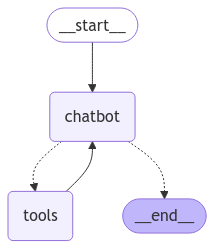

In [60]:
visualize_graph(graph)

Now we can ask the bot questions outside its training data.

In [18]:
from langchain_core.messages import BaseMessage

while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("대화 종료!")
        break
    for event in graph.stream({"messages": [("user", user_input)]}):
        for value in event.values():
            if isinstance(value["messages"][-1], BaseMessage):
                print("Assistant:", value["messages"][-1].content)

User:  미국 대선 언제야


Assistant: [{'id': 'toolu_015UiDo3NKESgU9fKhXB2jDP', 'input': {'query': '미국 대선 일정'}, 'name': 'tavily_search_results_json', 'type': 'tool_use'}]
Assistant: [{"url": "https://namu.wiki/w/2024\ub144 \ubbf8\uad6d \ub300\ud1b5\ub839 \uc120\uac70", "content": "\uac1c\uc694 [\ud3b8\uc9d1] 2024\ub144 11\uc6d4 5\uc77c \uc5d0 \uc2dc\ud589 \uc608\uc815\uc778 \ubbf8\uad6d \ub300\ud1b5\ub839 \uc120\uac70. \ubbf8\uad6d \uc758 60\ubc88\uc9f8 \ub300\ud1b5\ub839 \uc120\uac70\uc774\uace0 \uc81c47\ub300 \ub300\ud1b5\ub839 \uc744 \uc120\ucd9c\ud558\uac70\ub098 46\ub300 \ub300\ud1b5\ub839 \uc870 \ubc14\uc774\ub4e0 \uc774 \uc7ac\uc120 \uc5d0 \ub3c4\uc804\ud558\ub294 \uc120\uac70\ub2e4. \uc0c1\ub300\ub294 \uc9c1\uc804 45\ub300 \ub300\ud1b5\ub839 \ub3c4\ub110\ub4dc \ud2b8\ub7fc\ud504 \ub85c, 1912\ub144 \ubbf8\uad6d \ub300\ud1b5\ub839 \uc120\uac70 \uc774\ud6c4 112\ub144\ub9cc\uc5d0 \uc804 ..."}, {"url": "https://www.bbc.com/korean/international-65186660", "content": "\ub354 \ubcf4\uae30\n\ubbf8 \uc911\uac04\uc

User:  q


대화 종료!


User:  q


Goodbye!


In [61]:
from langchain_core.messages import BaseMessage

while True:
    user_input = input("User: ")
    print("User:", user_input)
    if user_input.lower() in ["quit", "exit", "q"]:
        print("대화 종료!")
        break
    for event in graph.stream({"messages": [("user", user_input)]}):
        for value in event.values():
            if isinstance(value["messages"][-1], BaseMessage):
                print("Assistant:", value["messages"][-1].content)

User: 안녕
Assistant: 안녕하세요! 무엇을 도와드릴까요?

User: 오늘 한국의 주요 뉴스를 요약해 줘
Assistant: 
Assistant: [{"url": "https://www.yna.co.kr/theme/headlines-history", "content": "\uc8fc\uc694\ub274\uc2a4 | \uc5f0\ud569\ub274\uc2a4 \uc5f0\ud569\ub274\uc2a4 \ubcf8\ubb38 \ubc14\ub85c\uac00\uae30 \uba54\ub274 \ubc14\ub85c\uac00\uae30 \uad6d\uac00\uae30\uac04\ub274\uc2a4 \ud1b5\uc2e0\uc0ac \uc5f0\ud569\ub274\uc2a4 \uacbd\uc81c \ub274\uc2a4 \uac80\uc0c9\uc5b4 \uc785\ub825 \uc591\uc2dd \ub300\ud1b5\ub839\uc2e4 \"\u7f8e '\uc6b0\ud06c\ub77c\uc804 \uc7a5\uac70\ub9ac\ubbf8\uc0ac\uc77c \ud5c8\uc6a9' \ud55c\uad6d\uc5d0 \uc0ac\uc804\ud1b5\ubcf4\" \uccb4\uc721\ud68c \ub178\uc870, IOC\uc5d0 '\ube44\uc704 \ud610\uc758' \uc774\uae30\ud765 \ud68c\uc7a5 '\uc8fc\uc2dc' \ucd09\uad6c \uc11c\ud55c \u7f8e \uc5f0\ubc29\ud1b5\uc2e0\uc704\uc6d0\uc7a5\uc5d0 \ube45\ud14c\ud06c \uaddc\uc81c\ub860\uc790\u2026\ud55c\uad6d\uc5d0 \ub07c\uce60 \uc601\ud5a5\uc740 \ub300\ud1b5\ub839\uc2e4 \"\ud55c\uc911\uad00\uacc4 \ud56d\uc0c1 \uc2e0\uacbd\u

## All in one!

In [ ]:
from typing import Annotated

from langchain_anthropic import ChatAnthropic
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


tool = TavilySearchResults(max_results=2)
tools = [tool]
llm = ChatAnthropic(model="claude-3-haiku-20240307")
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.set_entry_point("chatbot")
graph = graph_builder.compile()

In [85]:
#gemini
from typing import Annotated

#gemini chatbot setting
from langchain_google_genai import ChatGoogleGenerativeAI

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


tool = TavilySearchResults(max_results=5)
tools = [tool]
llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash-exp", temperature=0)
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.set_entry_point("chatbot")
graph = graph_builder.compile()

Key 'title' is not supported in schema, ignoring
Key 'title' is not supported in schema, ignoring


## Part 3: 메모리 추가하기

우리의 챗봇은 이제 도구를 사용하여 사용자 질문에 답할 수 있지만, 이전 상호작용의 맥락을 기억하지 못합니다. 이는 일관성 있는 여러 턴의 대화를 하는 데 한계를 가져옵니다.

LangGraph는 **지속적인 체크포인트 저장**을 통해 이 문제를 해결합니다. 그래프를 컴파일할 때 `checkpointer`를 제공하고, 그래프를 호출할 때 `thread_id`를 제공하면, LangGraph는 각 단계 후 상태를 자동으로 저장합니다. 동일한 `thread_id`를 사용하여 그래프를 다시 호출하면, 그래프는 저장된 상태를 로드하여 챗봇이 이전 상태에서 계속 작업할 수 있게 합니다.

나중에 **체크포인트 저장**이 단순한 대화 메모리보다 _훨씬_ 더 강력하다는 것을 알게 될 것입니다. 이는 언제든지 복잡한 상태를 저장하고 복구하여 오류 복구, 인간-상호작용 워크플로우, 시간 여행 상호작용 등을 가능하게 합니다. 하지만 너무 앞서 나가기 전에, 체크포인트를 추가하여 여러 턴의 대화를 가능하게 해 봅시다.

시작하려면, `SqliteSaver` 체크포인터를 생성하세요.

In [64]:
# pip install langgraph-checkpoint-sqlite

In [65]:
from langgraph.checkpoint.sqlite import SqliteSaver

# In memory:
memory = SqliteSaver.from_conn_string(":memory:")

# To disk:
# memory = SqliteSaver.from_conn_string("checkpoints.sqlite")

우리는 Sqlite DB 경로로 `:memory`를 지정했습니다. 이는 튜토리얼을 위해 편리한데, 모든 것을 메모리에 저장합니다. 실제 응용 프로그램에서는 이를 변경하여 자체 DB에 연결하거나 다른 체크포인터 클래스를 사용하는 것이 좋습니다.

다음으로 그래프를 정의하세요. 이미 `BasicToolNode`를 직접 구축했으므로, LangGraph의 사전 구축된 `ToolNode`와 `tools_condition`으로 이를 교체할 것입니다. 이들은 병렬 API 실행과 같은 유용한 기능을 제공합니다. 그 외의 내용은 모두 2부에서 복사해온 것입니다.

In [21]:
from typing import Annotated

from langchain_anthropic import ChatAnthropic
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


tool = TavilySearchResults(max_results=2)
tools = [tool]
llm = ChatAnthropic(model="claude-3-haiku-20240307")
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.set_entry_point("chatbot")

In [86]:
#gemini
from typing import Annotated

#gemini chatbot setting
from langchain_google_genai import ChatGoogleGenerativeAI

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


tool = TavilySearchResults(max_results=2)
tools = [tool]
llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash-exp", temperature=0)
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.set_entry_point("chatbot")

Key 'title' is not supported in schema, ignoring
Key 'title' is not supported in schema, ignoring


In [87]:
graph = graph_builder.compile()

Finally, compile the graph with the provided checkpointer.

In [90]:
graph = graph_builder.compile(checkpointer=memory)

Notice the connectivity of the graph hasn't changed since Part 2. All we are doing is checkpointing the `State` as the graph works through each node.

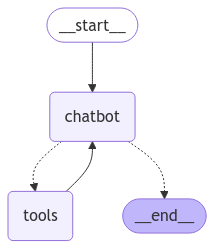

In [91]:
visualize_graph(graph)

In [92]:
config = {"configurable": {"thread_id": "1"}}

In [94]:
# invoke 사용하기
# Full State 형태로 하기
#invoke {"messages":[HumanMessage(content='안녕', additional_kwargs={}, response_metadata={}, id='model-0')]
while True:
    user_input = input("User: ")
    print("User: ", user_input)
    if user_input.lower() in ["quit", "exit", "q"]:
        print("대화 종료.")
        break
    ai = graph.invoke({"messages": [HumanMessage(content=user_input)]},config=config)
    #ai = graph.invoke({"messages": [HumanMessage(content=user_input,id='human-0')]})
    print("AI: ",ai['messages'][-1].content)

User:  안녕


AttributeError: '_GeneratorContextManager' object has no attribute 'get_next_version'

In [72]:
user_input = "안녕 나는 Liam이야."

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)


In [75]:
for event in events:
    event["messages"]

**참고:** 설정(config)은 그래프를 호출할 때 **두 번째 위치 인자**로 제공되었습니다. 중요한 점은 그래프 입력(`{'messages': []}`) 내에 포함되지 않는다는 것입니다.

이름을 기억하는지 확인해봅시다.


In [79]:
user_input = "내 이름 기억해?"

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    print(event["messages"])

AttributeError: '_GeneratorContextManager' object has no attribute 'get_next_version'

**참고**: 메모리 관리를 위해 외부 리스트를 사용하지 않는다는 점에 유의하세요. 이는 모두 체크포인터에 의해 처리됩니다.

In [27]:
# The only difference is we change the `thread_id` here to "2" instead of "1"
events = graph.stream(
    {"messages": [("user", user_input)]},
    {"configurable": {"thread_id": "2"}},
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

내 이름 기억해?
================================== Ai Message ==================================

[{'id': 'toolu_01N3aSPfj8jGx8jGwh3kQPJS', 'input': {'query': '내 이름 기억해'}, 'name': 'tavily_search_results_json', 'type': 'tool_use'}]
Tool Calls:
  tavily_search_results_json (toolu_01N3aSPfj8jGx8jGwh3kQPJS)
 Call ID: toolu_01N3aSPfj8jGx8jGwh3kQPJS
  Args:
    query: 내 이름 기억해
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://hinative.com/questions/16690237", "content": "\ub0b4 \uc774\ub984\uc744 \uae30\uc5b5\ud574 (nae i-reum-eur gi-eog-hae ) Definition of \ub0b4 \uc774\ub984\uc744 \uae30\uc5b5\ud574 Remember my name. Sign up; Sign in; Question Updated on 28 Jun 2020 jinah_07. 28 Jun 2020. English (US) Japanese Korean Simplified Chinese (China) Question about Korean. What does ..."}, {"url": "https://m.blog.naver.com/hasajon/223080615

**공지**: 앞선 강의에서 다뤘든 대화의 내용은 thread 별로 분리되어있습니다.

지금까지 우리는 두 개의 다른 스레드에서 몇 가지 체크포인트를 만들었습니다. 그렇다면 체크포인트에 무엇이 들어갈까요? 주어진 설정(config)에 대한 그래프의 `state`를 언제든지 검사하려면, `get_state(config)`를 호출하세요.

In [29]:
snapshot = graph.get_state(config)
snapshot

StateSnapshot(values={'messages': [HumanMessage(content='안녕 나는 Liam이야.', id='262865f3-01b8-45af-ad67-c48baef60a56'), AIMessage(content='반갑습니다 Liam! 저도 반가워요. 오늘 기분이 어떠신가요? 무엇을 하고 싶으신가요? 제가 도움이 되는 방법이 있다면 알려주세요.', response_metadata={'id': 'msg_018yywsXBpcJSb5GsioJSKtn', 'model': 'claude-3-haiku-20240307', 'stop_reason': 'end_turn', 'stop_sequence': None, 'usage': {'input_tokens': 381, 'output_tokens': 81}}, id='run-2d505fd2-9201-4b3d-9e37-15e4e47cfa09-0', usage_metadata={'input_tokens': 381, 'output_tokens': 81, 'total_tokens': 462}), HumanMessage(content='내 이름 기억해?', id='4cf69daf-e79a-4c2f-8adc-f50122477e06'), AIMessage(content='네, 당신의 이름이 Liam이라는 것을 잘 기억하고 있습니다. 처음 대화할 때 Liam이라고 소개해주셨죠. 저는 사용자분의 이름을 빠르게 기억하고 있으며, 이후 대화에서도 계속해서 사용자 이름을 활용할 것입니다. 이렇게 개인적인 대화를 나누게 되어 기쁩니다.', response_metadata={'id': 'msg_01EwuzNX457iGZB1Zp4Q7Cco', 'model': 'claude-3-haiku-20240307', 'stop_reason': 'end_turn', 'stop_sequence': None, 'usage': {'input_tokens': 475, 'output_tokens': 153}}, id='run-1b9cbd49-5e

In [30]:
snapshot.next  # (그래프가 이번 턴에 종료되었기 때문에, next는 비어 있습니다. 그래프 호출 중에 상태를 가져오면, next는 다음에 실행될 노드를 나타냅니다)

()

위의 스냅샷에는 현재 상태 값, 해당 구성(config), 그리고 처리할 `next` 노드가 포함되어 있습니다. 우리의 경우, 그래프는 `__end__` 상태에 도달했기 때문에 `next`는 비어 있습니다.

## All-in-one Again!

In [ ]:
from typing import Annotated

from langchain_anthropic import ChatAnthropic
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


tool = TavilySearchResults(max_results=2)
tools = [tool]
llm = ChatAnthropic(model="claude-3-haiku-20240307")
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.set_entry_point("chatbot")
graph = graph_builder.compile(checkpointer=memory)

In [95]:
#gemini
from typing import Annotated

#gemini chatbot setting
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


tool = TavilySearchResults(max_results=2)
tools = [tool]
llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash-exp", temperature=0)
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.set_entry_point("chatbot")
graph = graph_builder.compile(checkpointer=memory)

Key 'title' is not supported in schema, ignoring
Key 'title' is not supported in schema, ignoring
